In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_auc_score,classification_report,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_plot,pdp_isolate
from pdpbox.pdp import pdp_interact,pdp_interact_plot

In [2]:
#Loading the supreme court database
#data = pd.read_csv('data/SCDB_2018_02_caseCentered_Citation.csv',encoding='ISO 8859-1')
data = pd.read_csv('../data/SCDB_2019_01_caseCentered_Citation.csv',encoding='ISO 8859-1')
data.shape

(8966, 53)

In [3]:
#if AdminAction value is 117 in AdminAction if the action has been taken by State Agency
#creating this variables before normalising null values
data['is_adminAction'] = data['adminAction'].notna().astype(int)
data['is_adminActionState']=data['adminActionState'].notna().astype(int)
data['case_argued']=(data['dateArgument'].notna()).astype(int)
data['case_reargued']=(data['dateRearg'].notna()).astype(int)

In [4]:
data['case_reargued'].value_counts()

0    8788
1     178
Name: case_reargued, dtype: int64

In [5]:
data['case_argued'].value_counts()

1    7926
0    1040
Name: case_argued, dtype: int64

In [6]:
#Selecting all float columns, they should have been int cols, due to Null values they are designated as Float columns
float_columns = data.select_dtypes('float64').columns
#Replacing all null values with 9999 to convert the float columns to Int
data[float_columns] = data[float_columns].fillna(-1)
for col in float_columns:
    data[col] = data[col].astype('int')


### Coding of the Variables

The Supreme Court Database has already been ordinal encoded for variou variable names. The coding values can be identified from the code base [book](https://github.com/vishnuyar/supreme-court-data/blob/master/data/SCDB_2018_02_codebook.pdf).

To make the Dashly app more user friendly and also for a information perspective, the variable names are required, the following dictionaries are created from the codebook

In [7]:

#Dictionary for variour state and Federal courts-- Values only which contribute more than 1% of data
court_dict = {
    
        -1: 'Not Applicable',
        48: 'California Central U.S. District Court',
        50: 'California Northern U.S. District Court',
        51: 'California Southern U.S. District Court',
        55: 'District Of Columbia U.S. District Court',
        58: 'Florida Southern U.S. District Court',
        66: 'Illinois Northern U.S. District Court',
        75: 'Louisiana Eastern U.S. District Court',
        80: 'Massachusetts U.S. District Court',
        81: 'Michigan Eastern U.S. District Court',
        92: 'New Jersey U.S. District Court',
        94: 'New York Eastern U.S. District Court',
        96: 'New York Southern U.S. District Court',
        109: 'Pennsylvania Eastern U.S. District Court',
        301: 'State Appellate Court',
        300: 'State Supreme Court',
        302: 'State Trial Court',
        121: 'Texas Southern U.S. District Court',
        32: 'U.S. Court of Appeals, District of Columbia',
        28: 'U.S. Court of Appeals, Eighth Circuit',
        31: 'U.S. Court of Appeals, Eleventh Circuit',
        8: 'U.S. Court of Appeals, Federal Circuit',
        25: 'U.S. Court of Appeals, Fifth Circuit',
        21: 'U.S. Court of Appeals, First Circuit',
        24: 'U.S. Court of Appeals, Fourth Circuit',
        29: 'U.S. Court of Appeals, Ninth Circuit',
        22: 'U.S. Court of Appeals, Second Circuit',
        27: 'U.S. Court of Appeals, Seventh Circuit',
        26: 'U.S. Court of Appeals, Sixth Circuit',
        30: 'U.S. Court of Appeals, Tenth Circuit',
        23: 'U.S. Court of Appeals, Third Circuit',
        3: 'U.S. Court of Claims, Court of Federal Claims',
        9: 'U.S. Tax Court',
        126: 'Virginia Eastern U.S. District Court',
        9999:'Other Courts'
                                }
#Dictionary for Petitioner and Respondent parties -- Values only which contribute more than 1% of data
parties_labels = {9999: 'Others',
                 28: 'State',
                 27: 'United States',
                 100: 'Person accused of crime',
                 126: 'Person convicted of crime',
                 19: 'Govt Official',
                 145: 'Employee',
                 151: 'Employer',
                 249: 'Union',
                 8: 'Govt Employee',
                 3: 'City,Town or Govt Unit',
                 106: 'Alien',
                 215: 'Prisoner',
                 382: 'Labor Board',
                 195: 'Owner',
                 240: 'Taxpayer'}

#Dictionary for Lower Court Decision or ruling 
lc_disposition_dict={1:'stay, petition, or motion granted',
                        2:'affirmed',
                        3:'reversed',
                        4:'reversed and remanded',
                        5:'vacated and remanded',
                        6:'affirmed and reversed (or vacated) in part',
                        7:'affirmed and reversed (or vacated) in part and remanded',
                        8:'vacated',
                        9:'petition denied or appeal dismissed',
                        10:'modify',
                        11:'remand',
                        12:'unusual disposition'}
#Dictionary for Cert Reasons given by Supreme Court for taking up a case
cert_labels_dict={1: 'case did not arise on cert or cert not granted',
 2: 'federal court conflict',
 3: 'federal court conflict and to resolve important or significant question',
 4: 'putative conflict',
 5: 'conflict between federal court and state court',
 6: 'state court conflict',
 7: 'federal court confusion or uncertainty',
 8: 'state court confusion or uncertainty',
 9: 'federal court and state court confusion or uncertainty',
 10: 'to resolve important or significant question',
 11: 'to resolve question presented',
 12: 'no reason given',
 13: 'other reason'}

#Dictionary for Jurdisdiciton values
jurisdiction_dict = {1: 'cert',
                    2: 'appeal',
                    3: 'bail',
                    4: 'certification',
                    5: 'docketing fee',
                    6: 'rehearing or restored to calendar for reargument',
                    7: 'injunction',
                    8: 'mandamus',
                    9: 'original',
                    10: 'prohibition',
                    12: 'stay',
                    13: 'writ of error',
                    14: 'writ of habeas corpus',
                    15: 'unspecified, other'    
}

In [8]:
#updatining caseOrigin with court dict values, other values will be replaced with 9999
data['caseOrigin']=data['caseOrigin'].apply(lambda x: x if x in court_dict.keys() else 9999)
#updatining caseSource with court dict values, other values will be replaced with 9999
data['caseSource']=data['caseSource'].apply(lambda x: x if x in court_dict.keys() else 9999)

In [9]:
#updatining petitioner with top 15 values, other values will be replaced with 9999
petition_category = data['petitioner'].value_counts(ascending=False)[:15].index.values
data['petitioner']=data['petitioner'].apply(lambda x: x if x in petition_category else 9999)
#updatining respondent with top 15 values, other values will be replaced with 9999
respondent_category = data['respondent'].value_counts(ascending=False)[:15].index.values
data['respondent']=data['respondent'].apply(lambda x: x if x in petition_category else 9999)

In [10]:
#Separating the variables based on data from the codebook
identity_variables = ['caseId', 'docketId', 'caseIssuesId', 'voteId', 'usCite','sctCite', 'ledCite',
                      'lexisCite', 'docket','caseName']

#Removing following variable from background
#adminAction and  adminActionState, being replaced with boolean features 
background_variables=['petitioner', 'petitionerState', 'respondent', 'respondentState','jurisdiction', 
                      'threeJudgeFdc', 'caseOrigin', 'caseOriginState',
                      'caseSource', 'caseSourceState','lcDisagreement', 'certReason', 'lcDisposition','issueArea']

outcome_variables = ['decisionType','declarationUncon','caseDisposition','caseDispositionUnusual',
                     'precedentAlteration','partyWinning']
vote_variables =['voteUnclear','majVotes','minVotes']

In [11]:
#Conveting date columns to date format
date_columns = ['dateArgument','dateRearg','dateDecision']
for col in date_columns:
    data[col]=pd.to_datetime(data[col],errors='coerce')

In [12]:
#Sorting the data based on decisiondate - this will  be Useful for creating
# Validation and Test Sets
data = data.sort_values('dateDecision').reset_index(drop=True)



In [13]:
#Removing unspecified  and decisions with null valuesfrom the database
data = data[data['partyWinning'].isin([0,1])]
data.shape
#19 rows have been removed

(8947, 57)

In [14]:
#majority class base prediction is
data['partyWinning'].value_counts(normalize=True)
#64% is base line prediction

1    0.639656
0    0.360344
Name: partyWinning, dtype: float64

In [15]:
#Getting the ROC value for baseline prediction
y_pred = np.ones(len(data))
y_true = data['partyWinning'].values
roc_auc_score(y_true,y_pred)

0.5

In [16]:
#new_features = ['case_argued','case_reargued','is_adminAction','is_adminActionState','argued_since','reargued_since']
new_features = ['case_argued','case_reargued','is_adminAction','is_adminActionState']

In [17]:
#The below variables were utilised but they didn't contribute to model performance, They have been discarded
#To prevent leakages, the prev outcomes and prev decision were used.
# prev_vote_variables = ['prev_'+item for item in vote_variables]
# prev_outcome_variables = ['prev_'+item for item in outcome_variables]
# #From previous same issue what was the decision and voting data 
# data[prev_vote_variables] = data.groupby('issueArea')[vote_variables].shift(1)
# data[prev_outcome_variables] = data.groupby('issueArea')[outcome_variables].shift(1)
#data['prev_votes']=data['prev_majVotes']+data['prev_minVotes']

In [18]:
#Sorting the data based on decisiondate - might be Useful for generating features,
#need to be careful for leakage issues
data['argued_since'] = (data['dateDecision']-data['dateArgument']).dt.days
data['reargued_since'] = (data['dateDecision']-data['dateRearg']).dt.days
#Update : After running some models after incorporating anti-leakage,
#realised this was not contributing to model performance and the same is being discared

In [19]:
#Setting a basic model to fit the data
target = 'partyWinning'
features = background_variables+new_features

In [20]:
#The test and valid sets have been selected based on equal ratio of wins and losses
#Also, to prevent using future decsions to predict past decsions, multi cross validation is not being utilised
testsize = 1000
test = data[-testsize:]
val = data[-testsize*2:-testsize]
train = data[:-testsize*2]
test.shape,val.shape,train.shape

((1000, 59), (1000, 59), (6947, 59))

In [21]:
#Checking for propinate ratio of wins and losses in the train valid and test sets
train[target].value_counts(normalize=True),val[target].value_counts(normalize=True),test[target].value_counts(normalize=True)

(1    0.63495
 0    0.36505
 Name: partyWinning, dtype: float64, 1    0.635
 0    0.365
 Name: partyWinning, dtype: float64, 1    0.677
 0    0.323
 Name: partyWinning, dtype: float64)

In [22]:
#Updating with Null values, 
train = train.fillna(-1)
test = test.fillna(-1)
val = val.fillna(-1)


In [23]:
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]
X_train = train[features]
y_train = train[target]

In [24]:
len(features)

18

In [25]:

#Using Random Forest for training the data
rfc = RandomForestClassifier(n_estimators=1000,random_state=31,min_samples_split=5,max_depth=10)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=31, verbose=0,
                       warm_start=False)

In [26]:

print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(X_val)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(X_val)))


ROC score for Train is: 0.8447284963673409
ROC score for Val is: 0.6669334483874447
Accuracy score for Train is: 0.7410392975385058
Accuracy score for Val is: 0.67


In [27]:
#using xgboost for training the model
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000,learning_rate=0.02,objective='binary:logistic',max_depth=5,min_samples_split=5,random_state=31)
xgboost.fit(X_train,y_train,eval_metric='auc',eval_set=[(X_train,y_train),(X_val,y_val)],early_stopping_rounds=250)

[0]	validation_0-auc:0.651321	validation_1-auc:0.604761
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 250 rounds.
[1]	validation_0-auc:0.657806	validation_1-auc:0.622168
[2]	validation_0-auc:0.65672	validation_1-auc:0.614553
[3]	validation_0-auc:0.659329	validation_1-auc:0.622285
[4]	validation_0-auc:0.659471	validation_1-auc:0.622845
[5]	validation_0-auc:0.658991	validation_1-auc:0.625106
[6]	validation_0-auc:0.665899	validation_1-auc:0.628448
[7]	validation_0-auc:0.669011	validation_1-auc:0.633582
[8]	validation_0-auc:0.670505	validation_1-auc:0.634697
[9]	validation_0-auc:0.669859	validation_1-auc:0.634881
[10]	validation_0-auc:0.672629	validation_1-auc:0.635196
[11]	validation_0-auc:0.674842	validation_1-auc:0.636842
[12]	validation_0-auc:0.674077	validation_1-auc:0.636775
[13]	validation_0-auc:0.676454	validation_1-auc:0.639944
[14]	validation_0-auc:0.676342	validation_1-auc:0.64066

[141]	validation_0-auc:0.72926	validation_1-auc:0.657254
[142]	validation_0-auc:0.729637	validation_1-auc:0.657185
[143]	validation_0-auc:0.72983	validation_1-auc:0.657344
[144]	validation_0-auc:0.72997	validation_1-auc:0.657297
[145]	validation_0-auc:0.730141	validation_1-auc:0.657396
[146]	validation_0-auc:0.730313	validation_1-auc:0.657674
[147]	validation_0-auc:0.730562	validation_1-auc:0.657735
[148]	validation_0-auc:0.730992	validation_1-auc:0.658127
[149]	validation_0-auc:0.731268	validation_1-auc:0.658348
[150]	validation_0-auc:0.731272	validation_1-auc:0.658468
[151]	validation_0-auc:0.731823	validation_1-auc:0.658943
[152]	validation_0-auc:0.731995	validation_1-auc:0.658934
[153]	validation_0-auc:0.732322	validation_1-auc:0.659314
[154]	validation_0-auc:0.732509	validation_1-auc:0.659435
[155]	validation_0-auc:0.732512	validation_1-auc:0.659336
[156]	validation_0-auc:0.733299	validation_1-auc:0.659836
[157]	validation_0-auc:0.733489	validation_1-auc:0.659845
[158]	validation_

[283]	validation_0-auc:0.763536	validation_1-auc:0.656771
[284]	validation_0-auc:0.763658	validation_1-auc:0.656775
[285]	validation_0-auc:0.763719	validation_1-auc:0.65663
[286]	validation_0-auc:0.763979	validation_1-auc:0.656516
[287]	validation_0-auc:0.764273	validation_1-auc:0.656236
[288]	validation_0-auc:0.764399	validation_1-auc:0.656374
[289]	validation_0-auc:0.764441	validation_1-auc:0.6563
[290]	validation_0-auc:0.764701	validation_1-auc:0.656365
[291]	validation_0-auc:0.764727	validation_1-auc:0.656438
[292]	validation_0-auc:0.764771	validation_1-auc:0.656434
[293]	validation_0-auc:0.765009	validation_1-auc:0.656434
[294]	validation_0-auc:0.765094	validation_1-auc:0.656456
[295]	validation_0-auc:0.765368	validation_1-auc:0.656279
[296]	validation_0-auc:0.76565	validation_1-auc:0.656085
[297]	validation_0-auc:0.765735	validation_1-auc:0.656037
[298]	validation_0-auc:0.765755	validation_1-auc:0.656093
[299]	validation_0-auc:0.76582	validation_1-auc:0.655869
[300]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=5, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=31, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [28]:
print("ROC score for Train is:",roc_auc_score(y_train,xgboost.predict_proba(X_train)[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(X_val)[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,xgboost.predict(X_train)))
print("Accuracy score for Val is:",accuracy_score(y_val,xgboost.predict(X_val)))


ROC score for Train is: 0.7369483607442536
ROC score for Val is: 0.6608089742206881
Accuracy score for Train is: 0.6915215200806103
Accuracy score for Val is: 0.665


In [29]:
#Permutation importance with randomforest
perm_xgboost = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm_xgboost,feature_names=features,top=None)

Weight,Feature
0.0350 ± 0.0156,certReason
0.0214 ± 0.0105,lcDisposition
0.0195 ± 0.0112,respondent
0.0177 ± 0.0176,case_argued
0.0163 ± 0.0081,petitioner
0.0131 ± 0.0109,issueArea
0.0113 ± 0.0102,lcDisagreement
0.0076 ± 0.0057,respondentState
0.0071 ± 0.0087,caseSource
0.0050 ± 0.0026,caseOriginState


In [30]:
#Permutation importance with randomforest
perm_rfc = PermutationImportance(rfc, random_state=1,scoring='roc_auc').fit(X_val, y_val)
eli5.show_weights(perm_rfc,feature_names=features,top=None)

Weight,Feature
0.0203 ± 0.0195,certReason
0.0203 ± 0.0071,respondent
0.0200 ± 0.0148,case_argued
0.0177 ± 0.0081,lcDisposition
0.0125 ± 0.0069,petitioner
0.0112 ± 0.0094,lcDisagreement
0.0081 ± 0.0058,issueArea
0.0075 ± 0.0065,caseSource
0.0071 ± 0.0023,caseSourceState
0.0068 ± 0.0044,respondentState


In [31]:
#Selecting features from perumation importances
feature_importances_rfc = pd.Series(dict(zip(features,perm_rfc.feature_importances_)))
feature_importances_xgb = pd.Series(dict(zip(features,perm_xgboost.feature_importances_)))
#feature_importances.sort_values().plot(kind='barh',figsize=(10,6))

In [32]:
selected_features_rfc = feature_importances_rfc[feature_importances_rfc >0].sort_values(ascending=False).index.tolist()
selected_features_xgb = feature_importances_xgb[feature_importances_xgb >0].sort_values(ascending=False).index.tolist()


In [33]:
len(selected_features_rfc),len(selected_features_xgb)

(15, 14)

In [34]:
#Selected final features for the model using the union of importance features in both randomfores and xgboost
selected_features = list((set(selected_features_rfc)|set(selected_features_xgb)))
selected_features

['caseSource',
 'caseOriginState',
 'respondent',
 'lcDisagreement',
 'issueArea',
 'case_reargued',
 'case_argued',
 'lcDisposition',
 'respondentState',
 'caseSourceState',
 'threeJudgeFdc',
 'petitioner',
 'is_adminAction',
 'certReason',
 'petitionerState']

In [35]:
len(selected_features)

15

In [36]:
#Trainig the randomforest model with selected features and predicting the score on test data now
rfc.fit(train[selected_features],y_train)
print("ROC score for Train is:",roc_auc_score(y_train,rfc.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,rfc.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,rfc.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,rfc.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,rfc.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,rfc.predict(test[selected_features])))

ROC score for Train is: 0.8354032022753555
ROC score for Val is: 0.6670585697335778
ROC score for Test is: 0.6536806435238326
Accuracy score for Train is: 0.7321145818338851
Accuracy score for Val is: 0.661
Accuracy score for Test is: 0.673


In [37]:
#Trainig the xgboost model with selected features and predicting the score on test data now

xgboost.fit(train[selected_features],y_train,eval_metric='auc',eval_set=[(train[selected_features],y_train),(val[selected_features],y_val)],early_stopping_rounds=100)

[0]	validation_0-auc:0.651351	validation_1-auc:0.605635
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.657937	validation_1-auc:0.623339
[2]	validation_0-auc:0.656912	validation_1-auc:0.615759
[3]	validation_0-auc:0.659409	validation_1-auc:0.623357
[4]	validation_0-auc:0.659214	validation_1-auc:0.621169
[5]	validation_0-auc:0.658847	validation_1-auc:0.624176
[6]	validation_0-auc:0.665714	validation_1-auc:0.629796
[7]	validation_0-auc:0.668879	validation_1-auc:0.63352
[8]	validation_0-auc:0.670499	validation_1-auc:0.634993
[9]	validation_0-auc:0.669811	validation_1-auc:0.634702
[10]	validation_0-auc:0.672512	validation_1-auc:0.637139
[11]	validation_0-auc:0.675134	validation_1-auc:0.640304
[12]	validation_0-auc:0.675597	validation_1-auc:0.64124
[13]	validation_0-auc:0.675566	validation_1-auc:0.641728
[14]	validation_0-auc:0.676999	validation_1-auc:0.641577

[141]	validation_0-auc:0.729548	validation_1-auc:0.654876
[142]	validation_0-auc:0.729983	validation_1-auc:0.65473
[143]	validation_0-auc:0.73014	validation_1-auc:0.654833
[144]	validation_0-auc:0.730127	validation_1-auc:0.655256
[145]	validation_0-auc:0.7301	validation_1-auc:0.655064
[146]	validation_0-auc:0.730602	validation_1-auc:0.654842
[147]	validation_0-auc:0.731187	validation_1-auc:0.65482
[148]	validation_0-auc:0.731339	validation_1-auc:0.654989
[149]	validation_0-auc:0.731645	validation_1-auc:0.655301
[150]	validation_0-auc:0.731755	validation_1-auc:0.655129
[151]	validation_0-auc:0.73189	validation_1-auc:0.655383
[152]	validation_0-auc:0.732102	validation_1-auc:0.655125
[153]	validation_0-auc:0.732651	validation_1-auc:0.65528
[154]	validation_0-auc:0.733104	validation_1-auc:0.655051
[155]	validation_0-auc:0.733086	validation_1-auc:0.655043
[156]	validation_0-auc:0.733857	validation_1-auc:0.654812
[157]	validation_0-auc:0.734013	validation_1-auc:0.654842
[158]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=5, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=31, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [38]:
print("ROC score for Train is:",roc_auc_score(y_train,xgboost.predict_proba(train[selected_features])[:,1]))
print("ROC score for Val is:",roc_auc_score(y_val,xgboost.predict_proba(val[selected_features])[:,1]))
print("ROC score for Test is:",roc_auc_score(y_test,xgboost.predict_proba(test[selected_features])[:,1]))
print("Accuracy score for Train is:",accuracy_score(y_train,xgboost.predict(train[selected_features])))
print("Accuracy score for Val is:",accuracy_score(y_val,xgboost.predict(val[selected_features])))
print("Accuracy score for Test is:",accuracy_score(y_test,xgboost.predict(test[selected_features])))

ROC score for Train is: 0.7386724792549741
ROC score for Val is: 0.6571631970661201
ROC score for Test is: 0.6551028714369989
Accuracy score for Train is: 0.6923852022455736
Accuracy score for Val is: 0.662
Accuracy score for Test is: 0.674


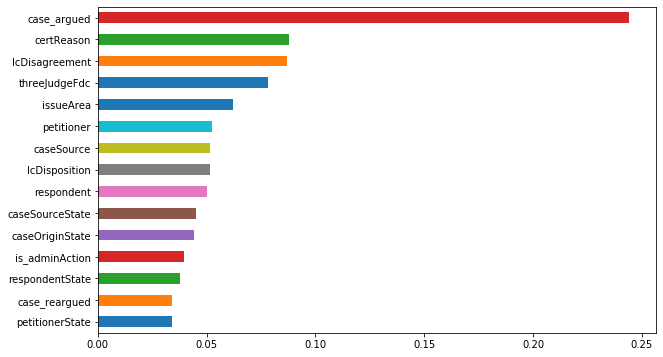

In [39]:
#Selected Feature Importances of the model from Random Forest Classifier
pd.Series(dict(zip(selected_features,xgboost.feature_importances_))).sort_values().plot(kind='barh',figsize=(10,6));

In [40]:
#Classification report for Test based on RandomForestClassifier
print(classification_report(y_test,rfc.predict(test[selected_features])))

              precision    recall  f1-score   support

           0       0.48      0.16      0.24       323
           1       0.70      0.92      0.79       677

    accuracy                           0.67      1000
   macro avg       0.59      0.54      0.52      1000
weighted avg       0.63      0.67      0.61      1000



In [41]:
#Classification report for Test based on Xgboost
print(classification_report(y_test,xgboost.predict(test[selected_features])))

              precision    recall  f1-score   support

           0       0.49      0.20      0.28       323
           1       0.70      0.90      0.79       677

    accuracy                           0.67      1000
   macro avg       0.59      0.55      0.53      1000
weighted avg       0.63      0.67      0.62      1000



In [76]:
#Getting the confsion matrix to plot it using heatmap  
#using the prediction from xgboost
con_matrix = pd.DataFrame(confusion_matrix(y_test,xgboost.predict(test[selected_features])))
con_matrix.index = ['Negative','Positive']
con_matrix.columns = ['Predicted Negative','Predicted Positive']
con_matrix

,Predicted Negative,Predicted Positive
Negative,63,260
Positive,66,611


In [88]:
plt.rcParams['figure.dpi'] = 150

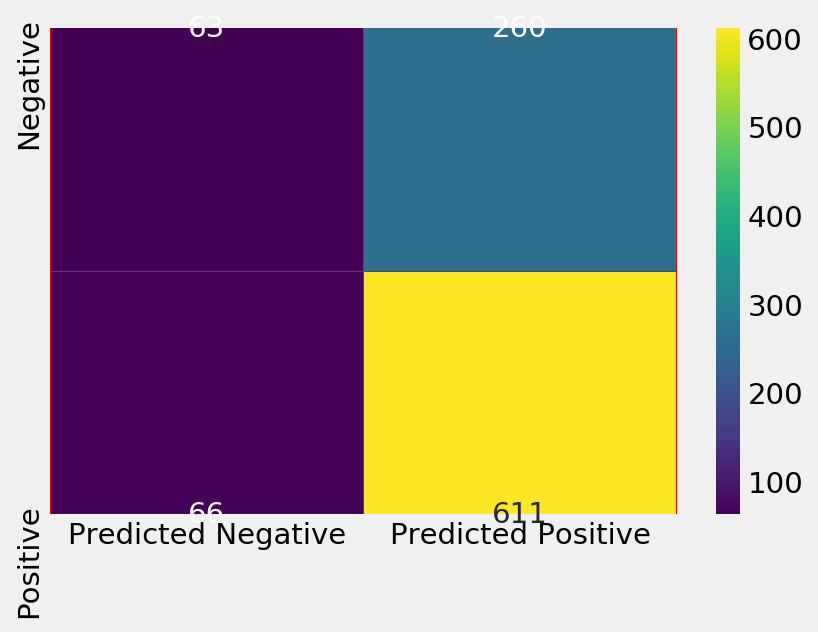

In [89]:
confusion_matrix_fig = sns.heatmap(con_matrix,annot=True,fmt='d',cmap='viridis',linewidths=0.2,linecolor='red')
confusion_matrix_fig;

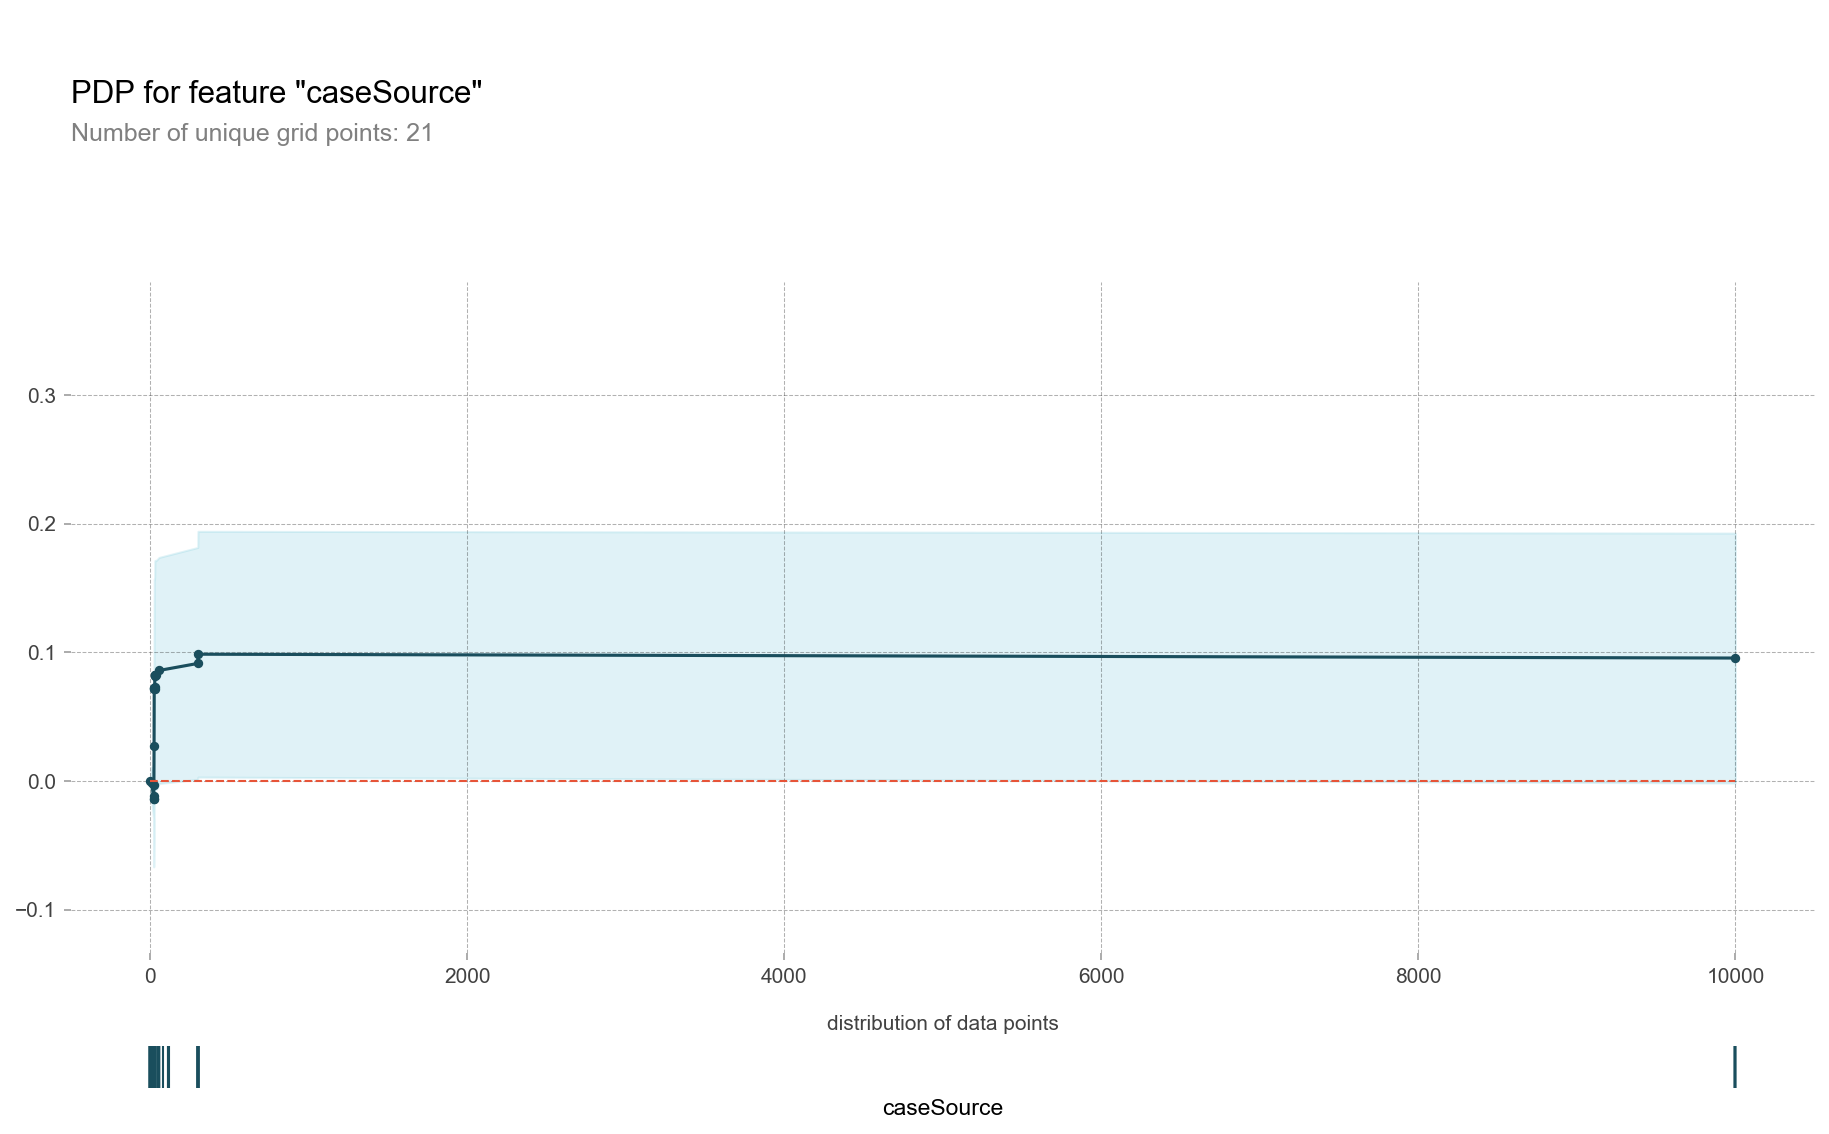

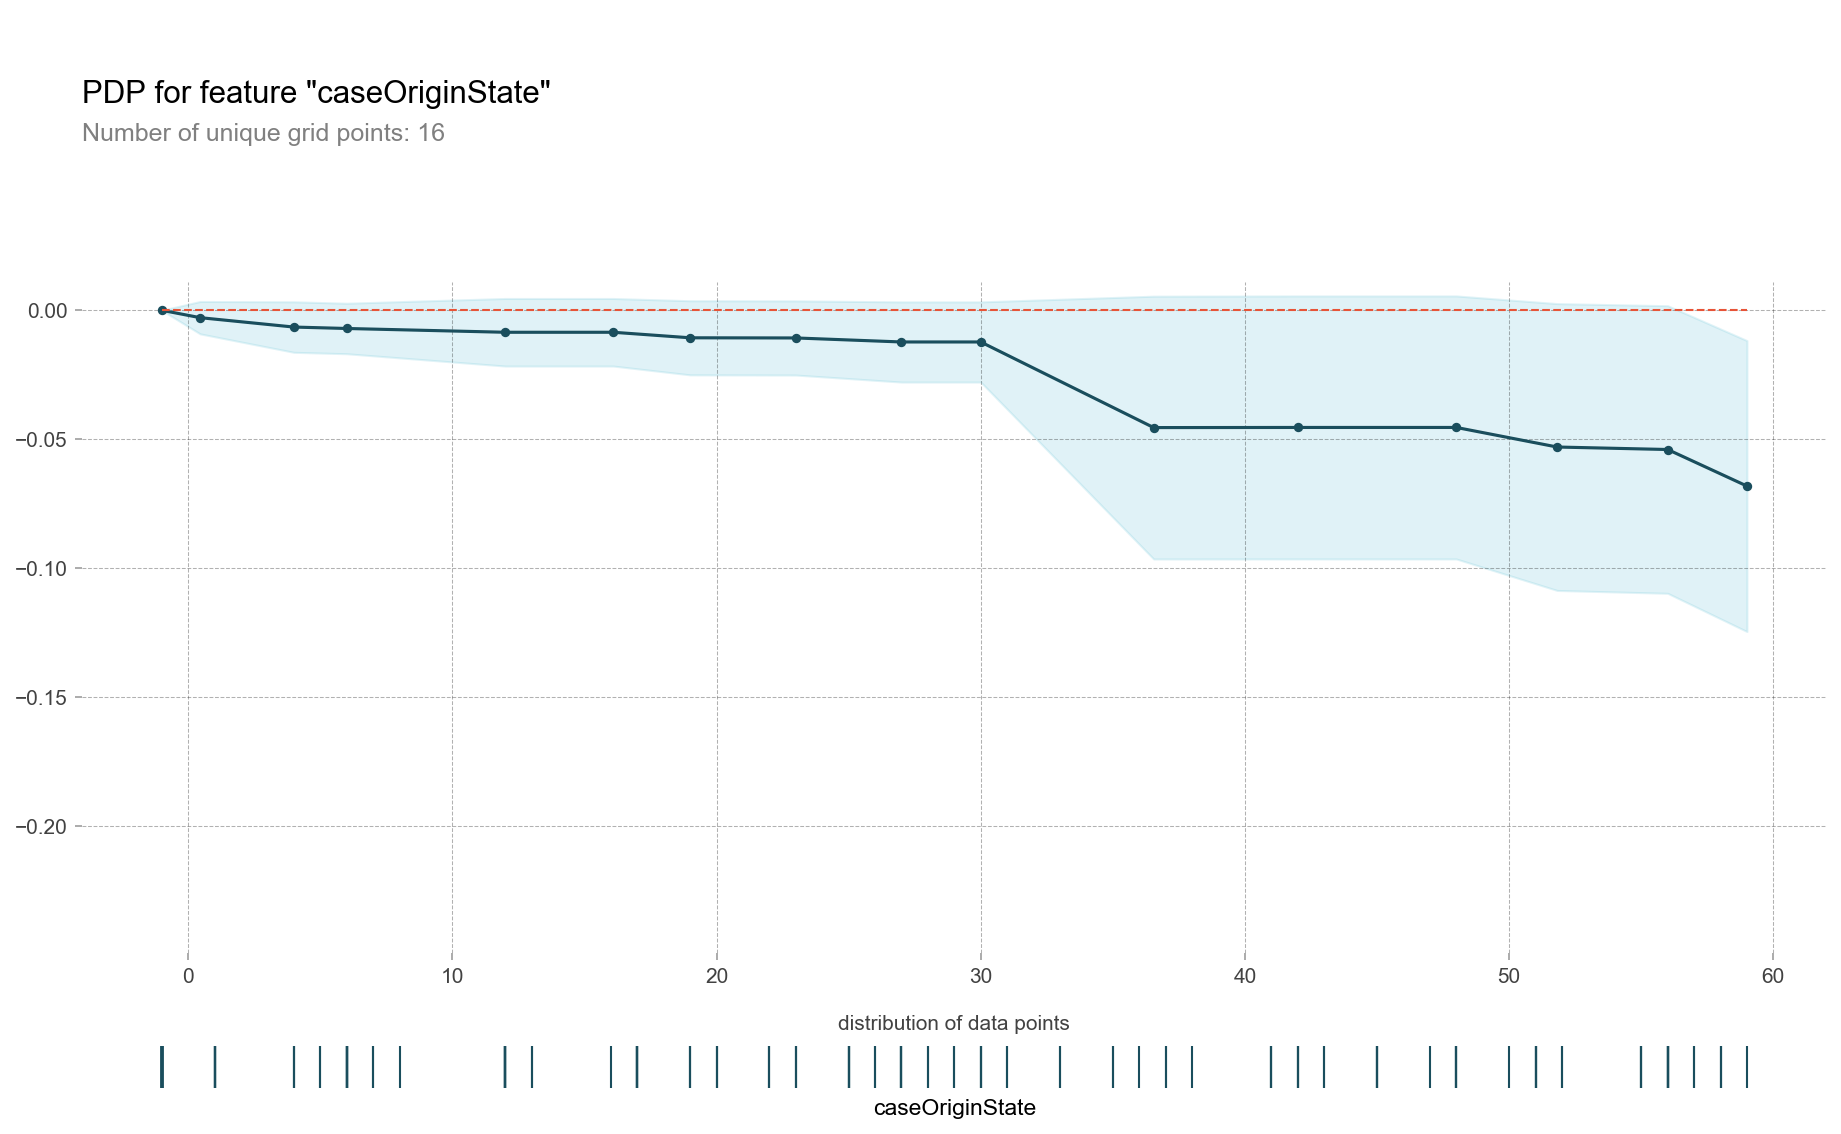

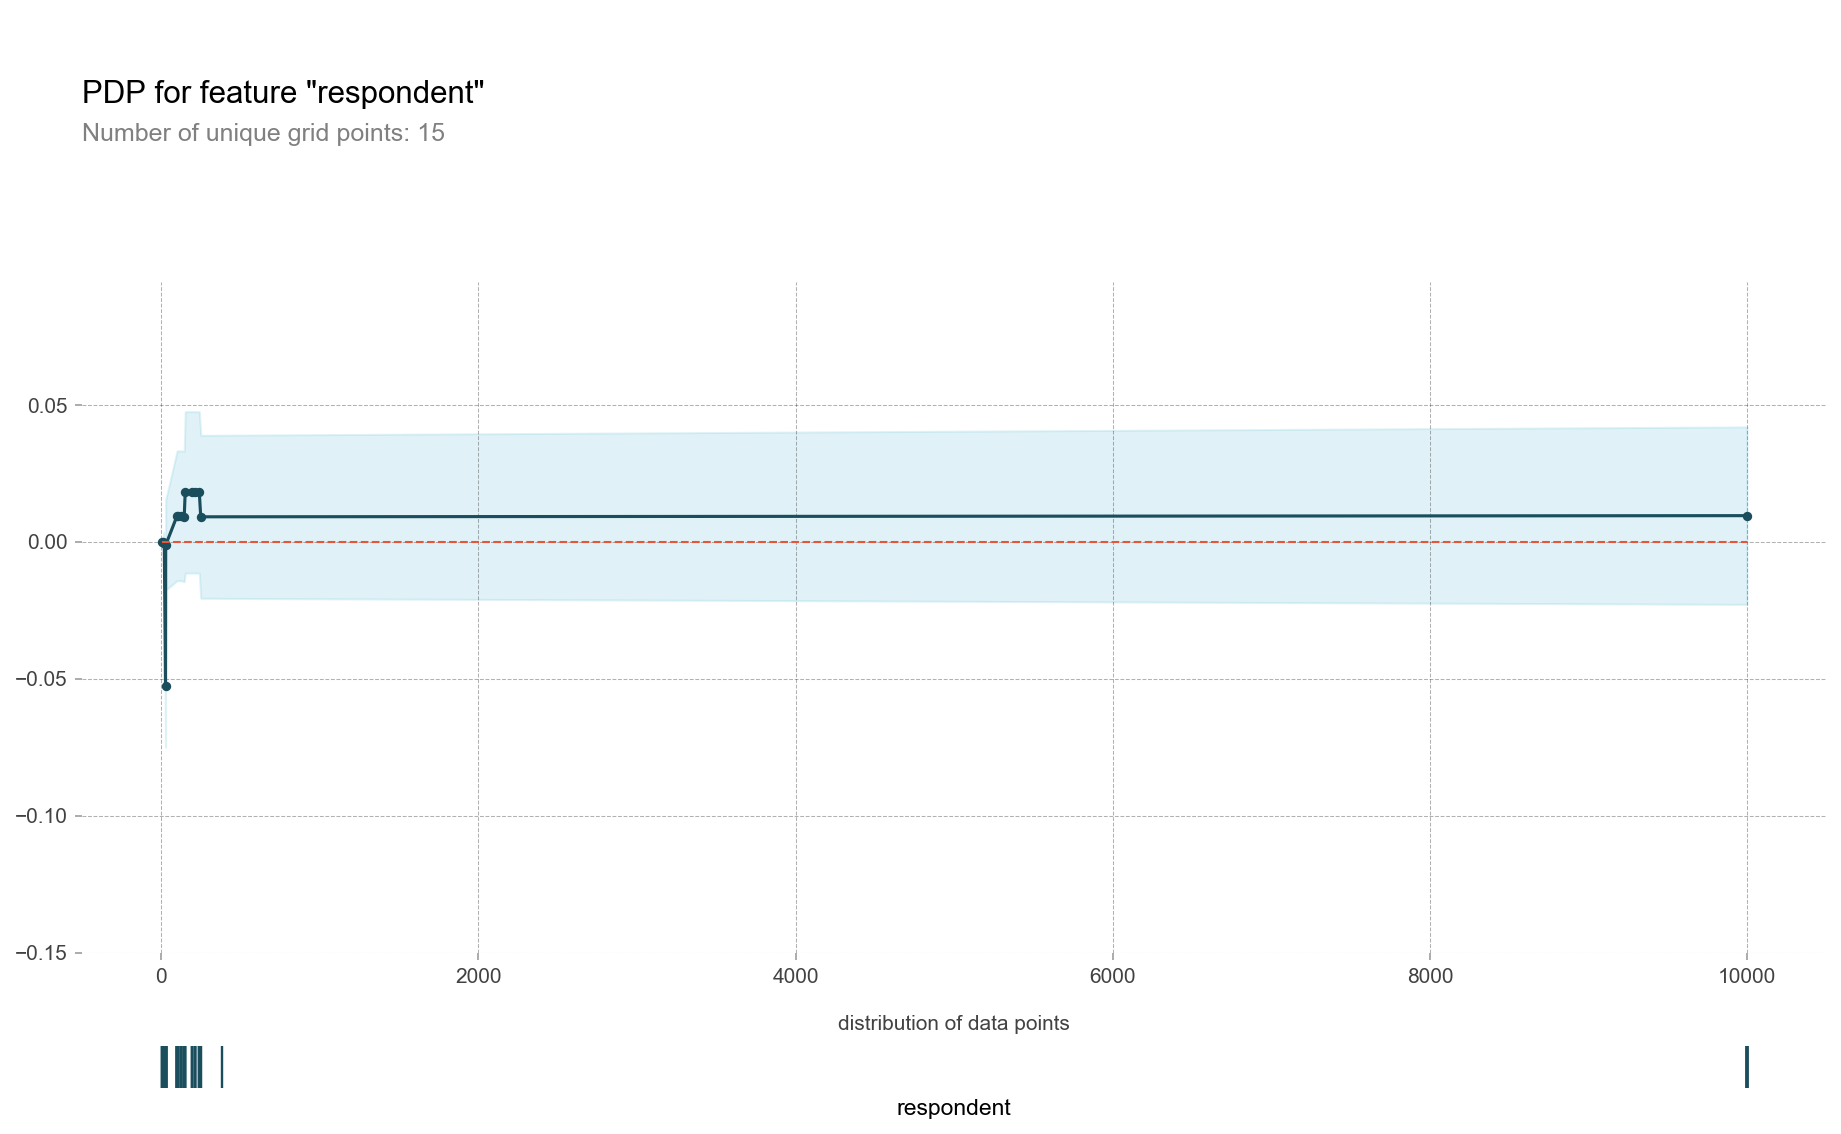

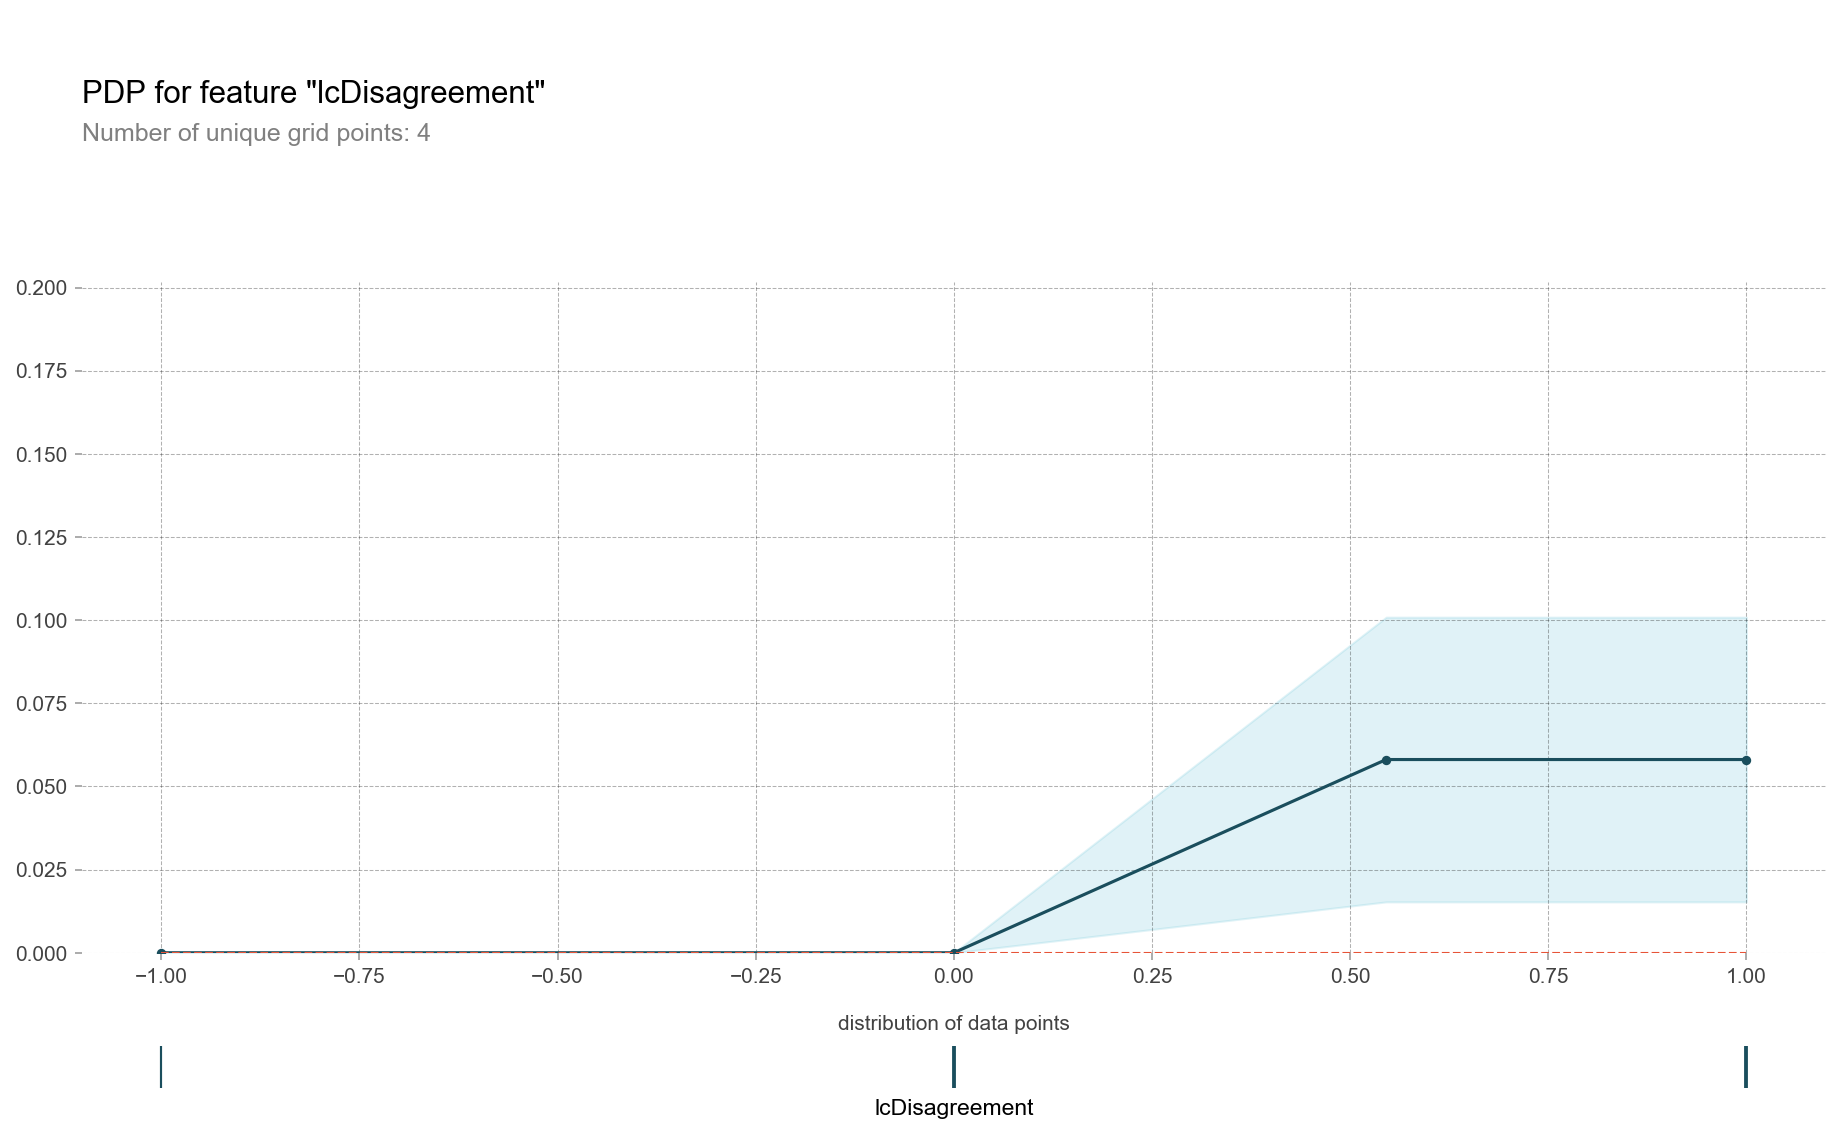

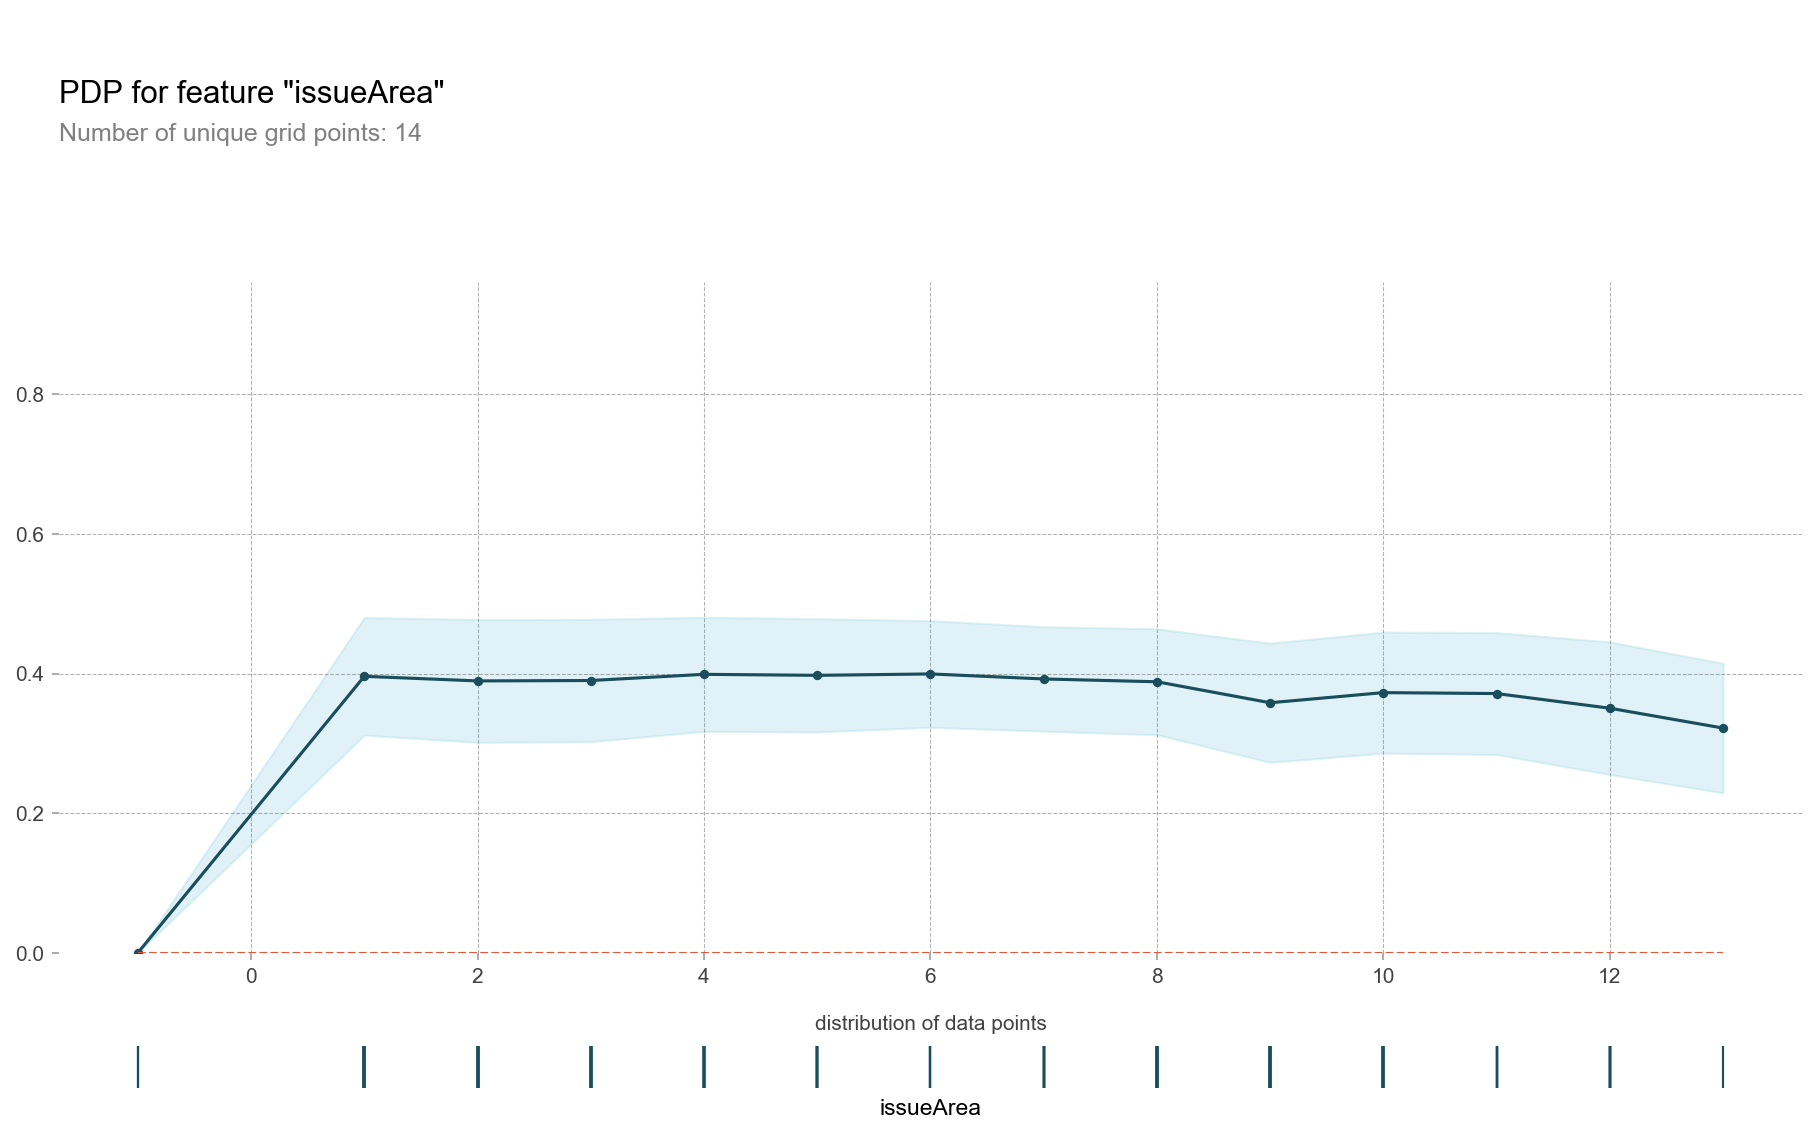

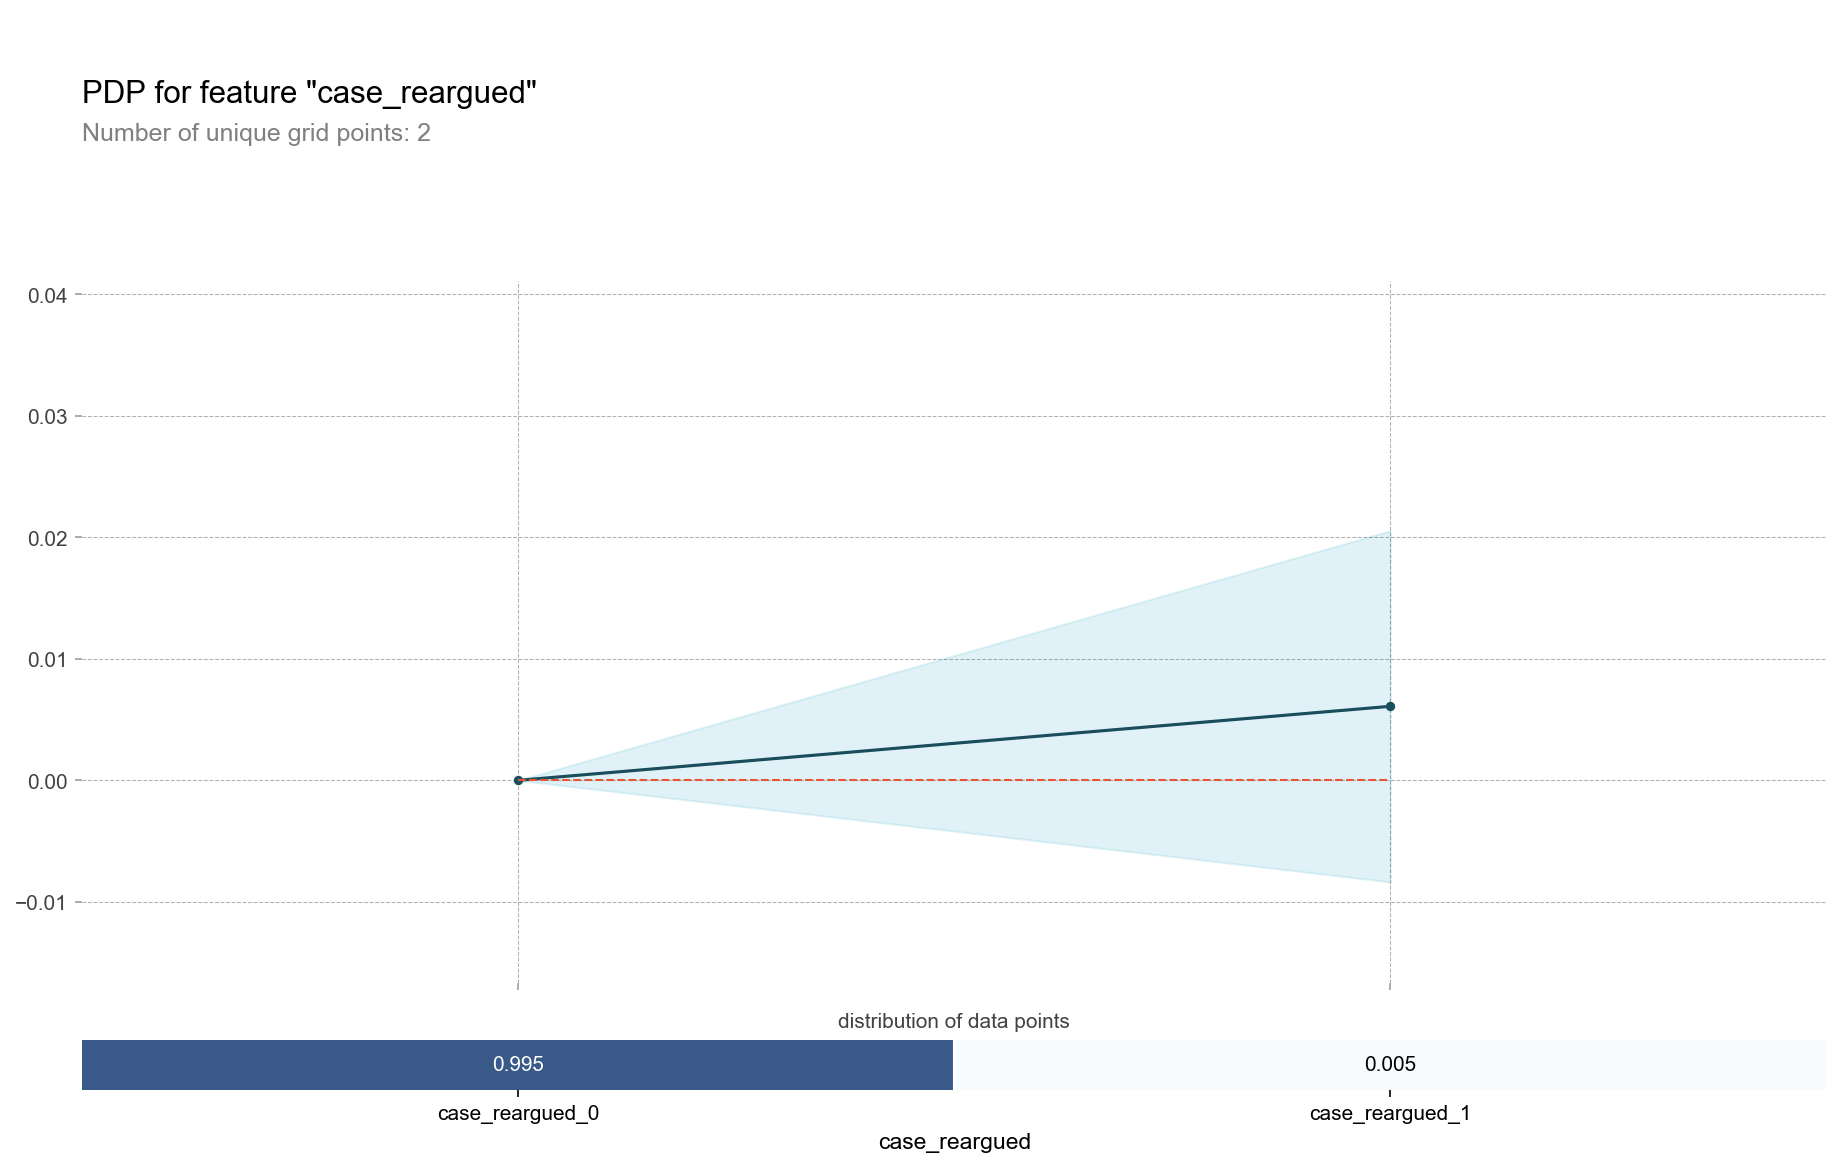

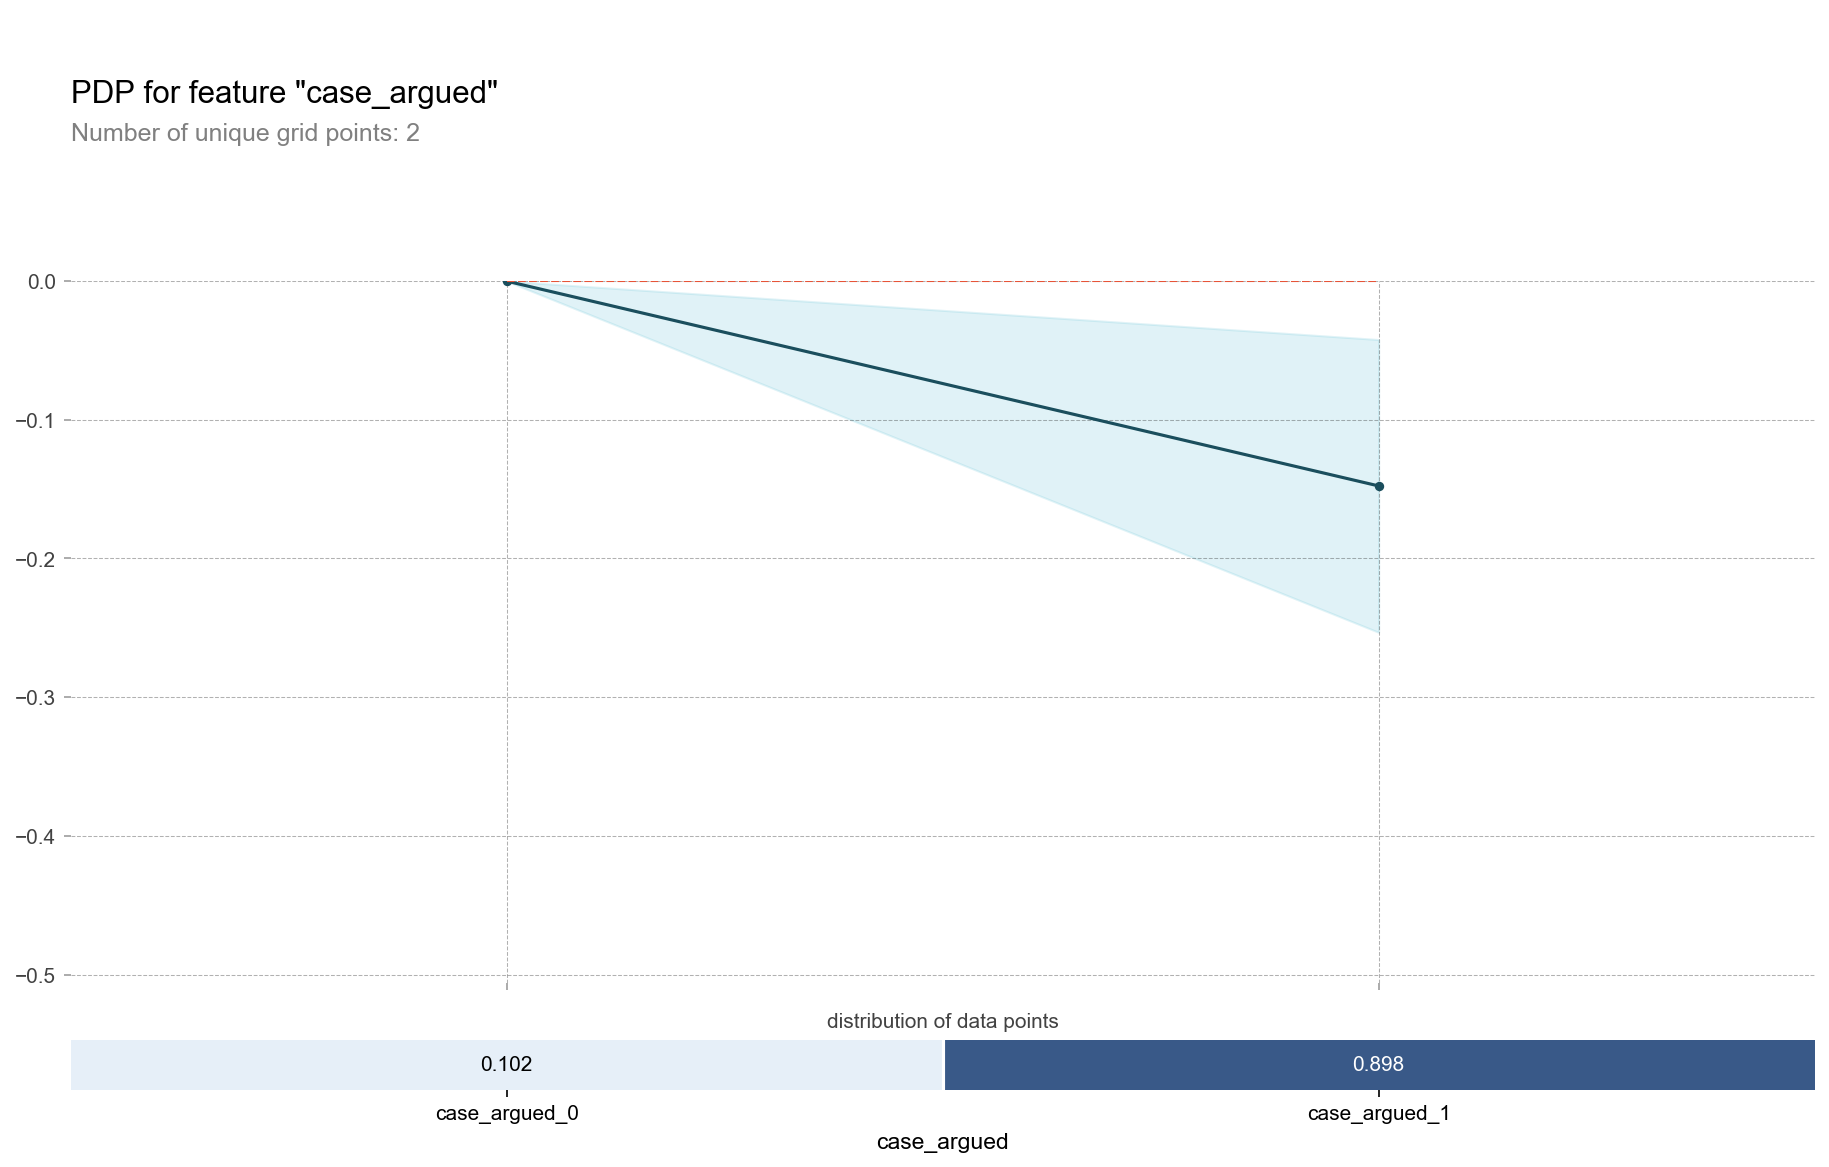

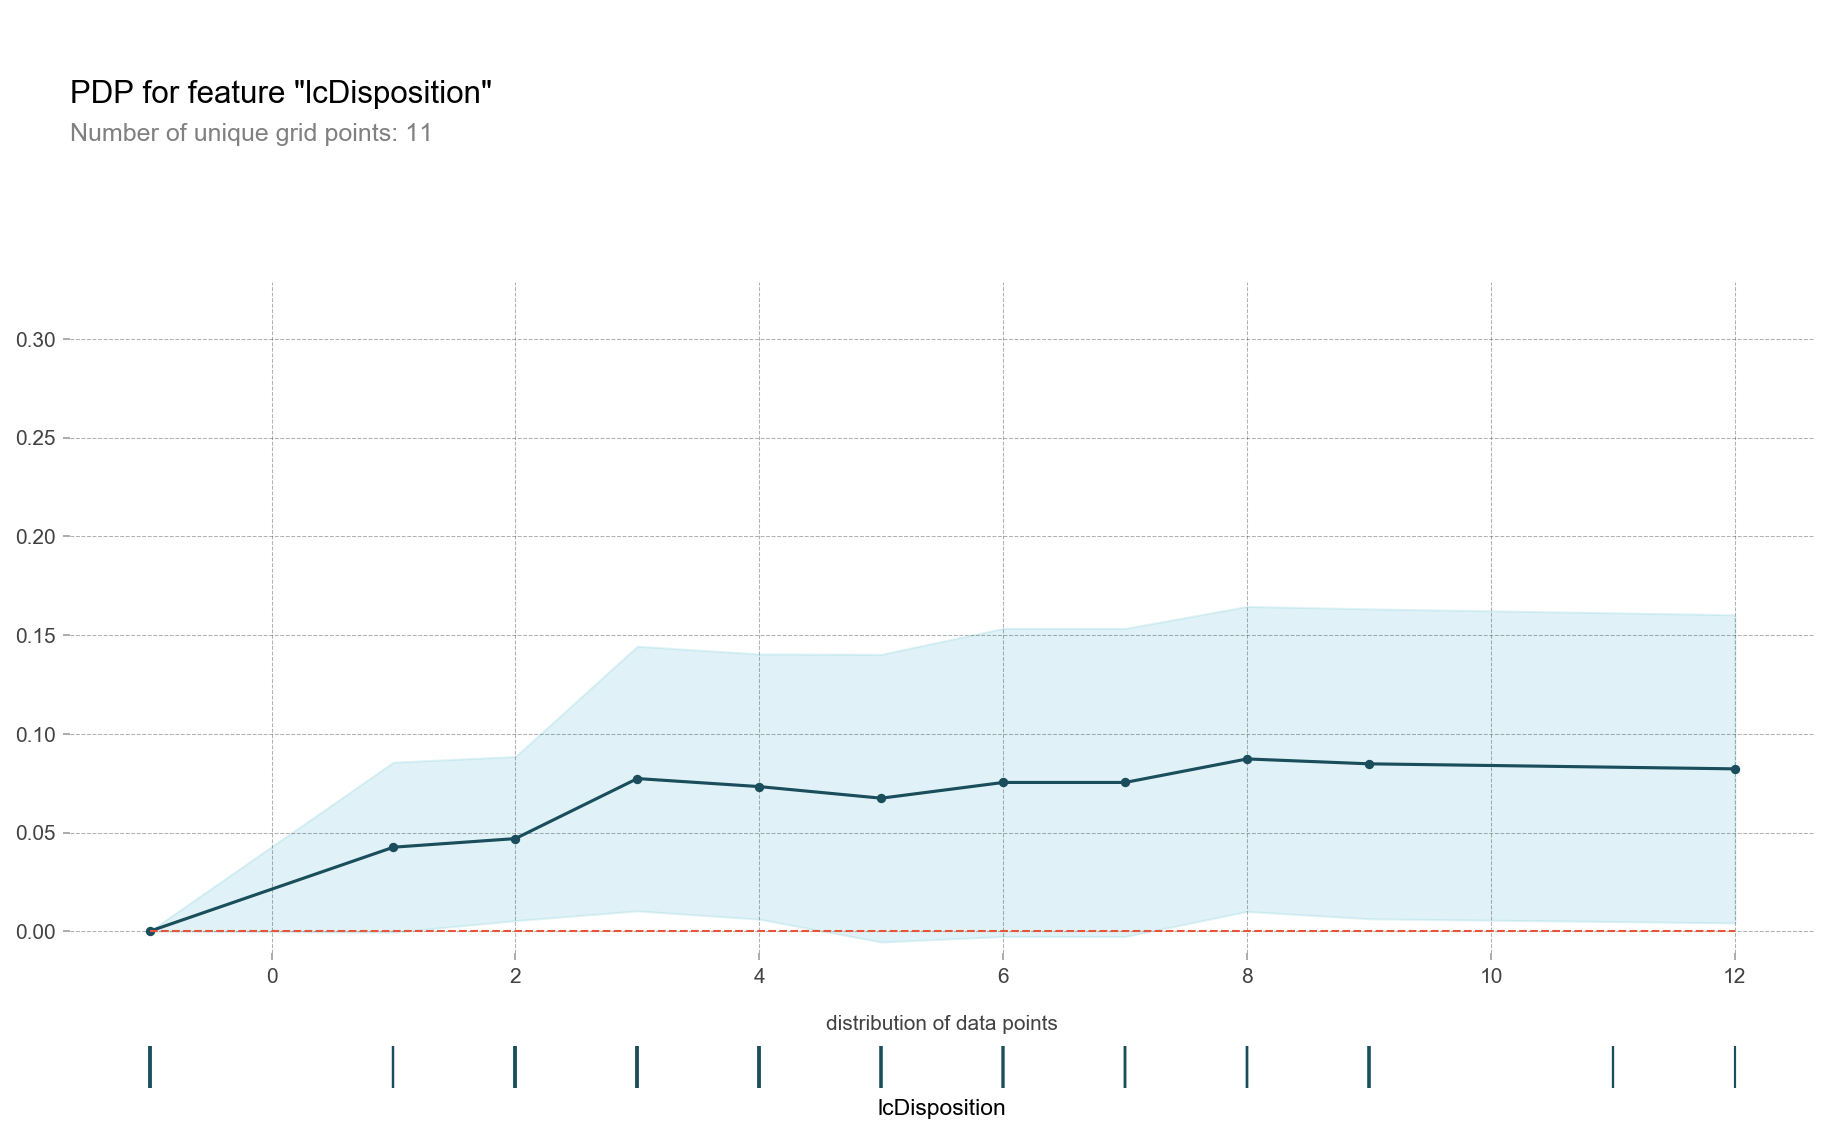

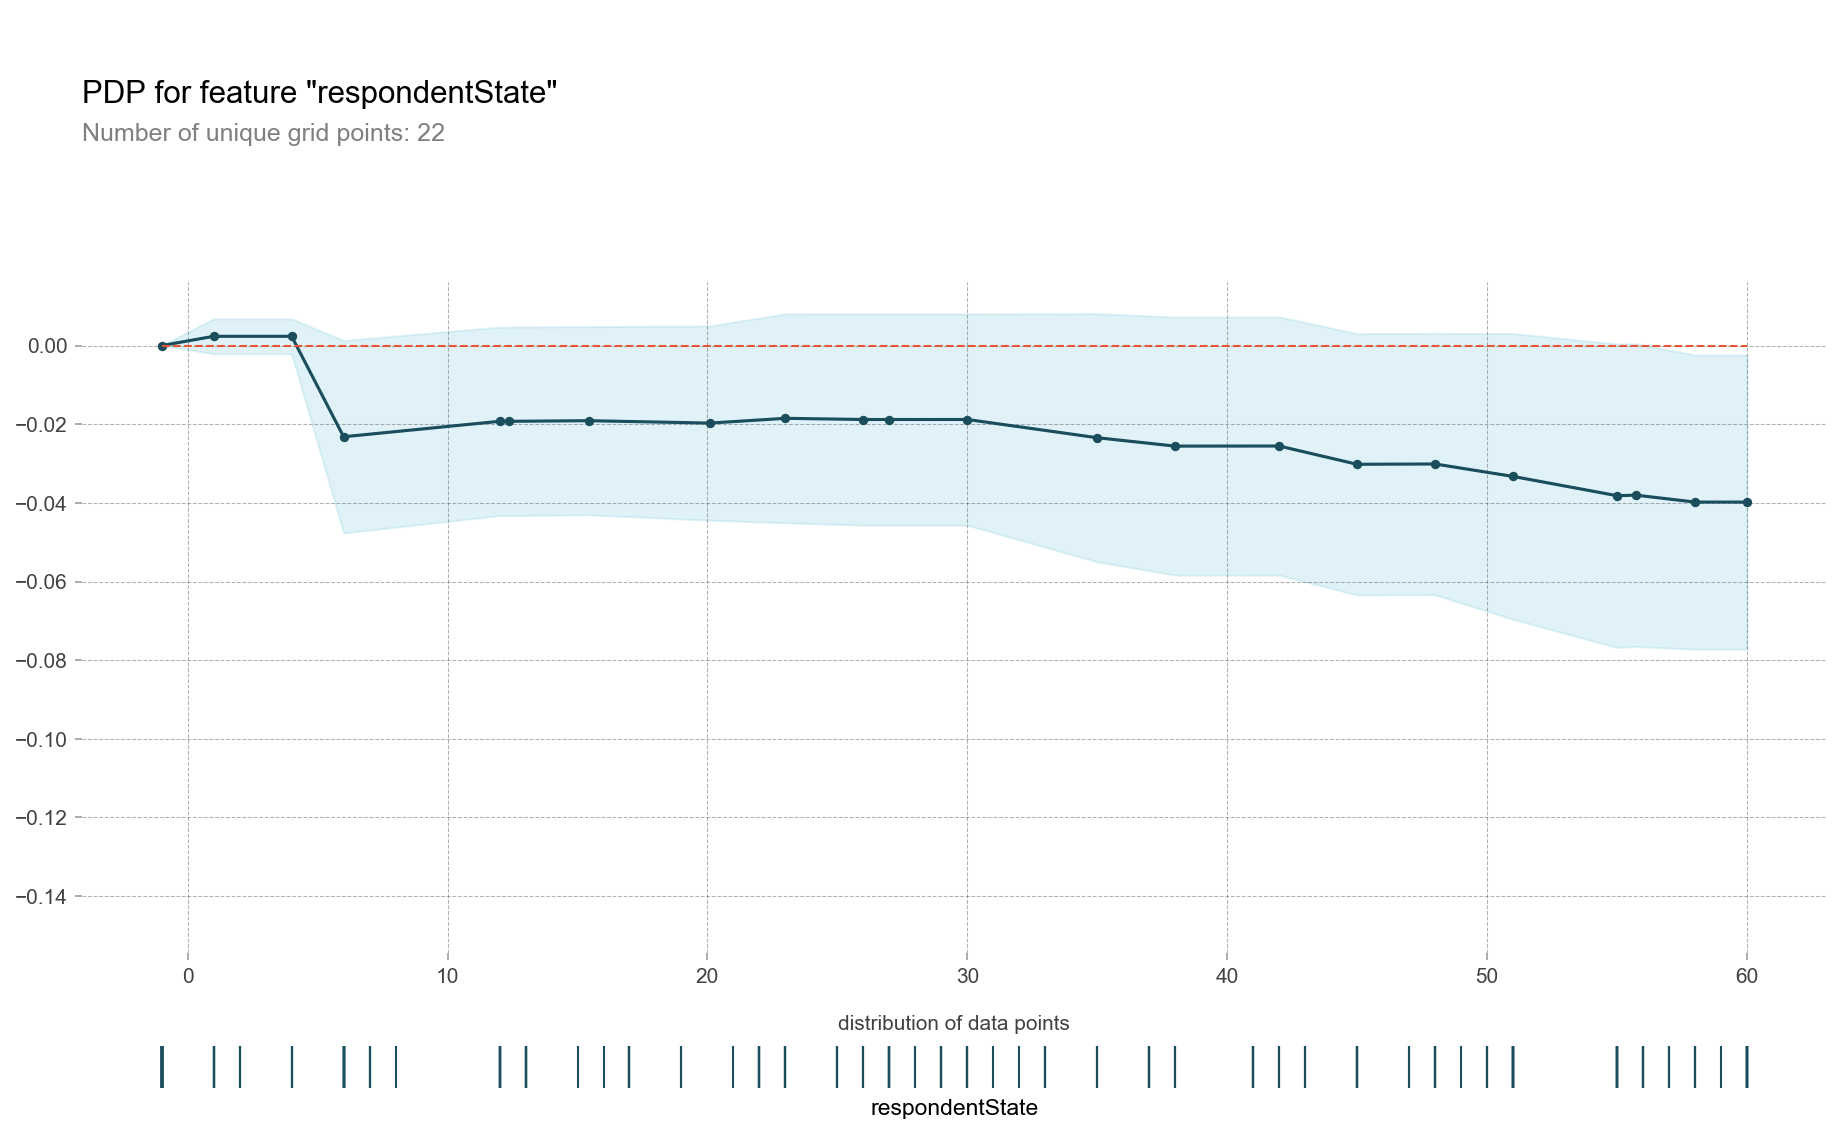

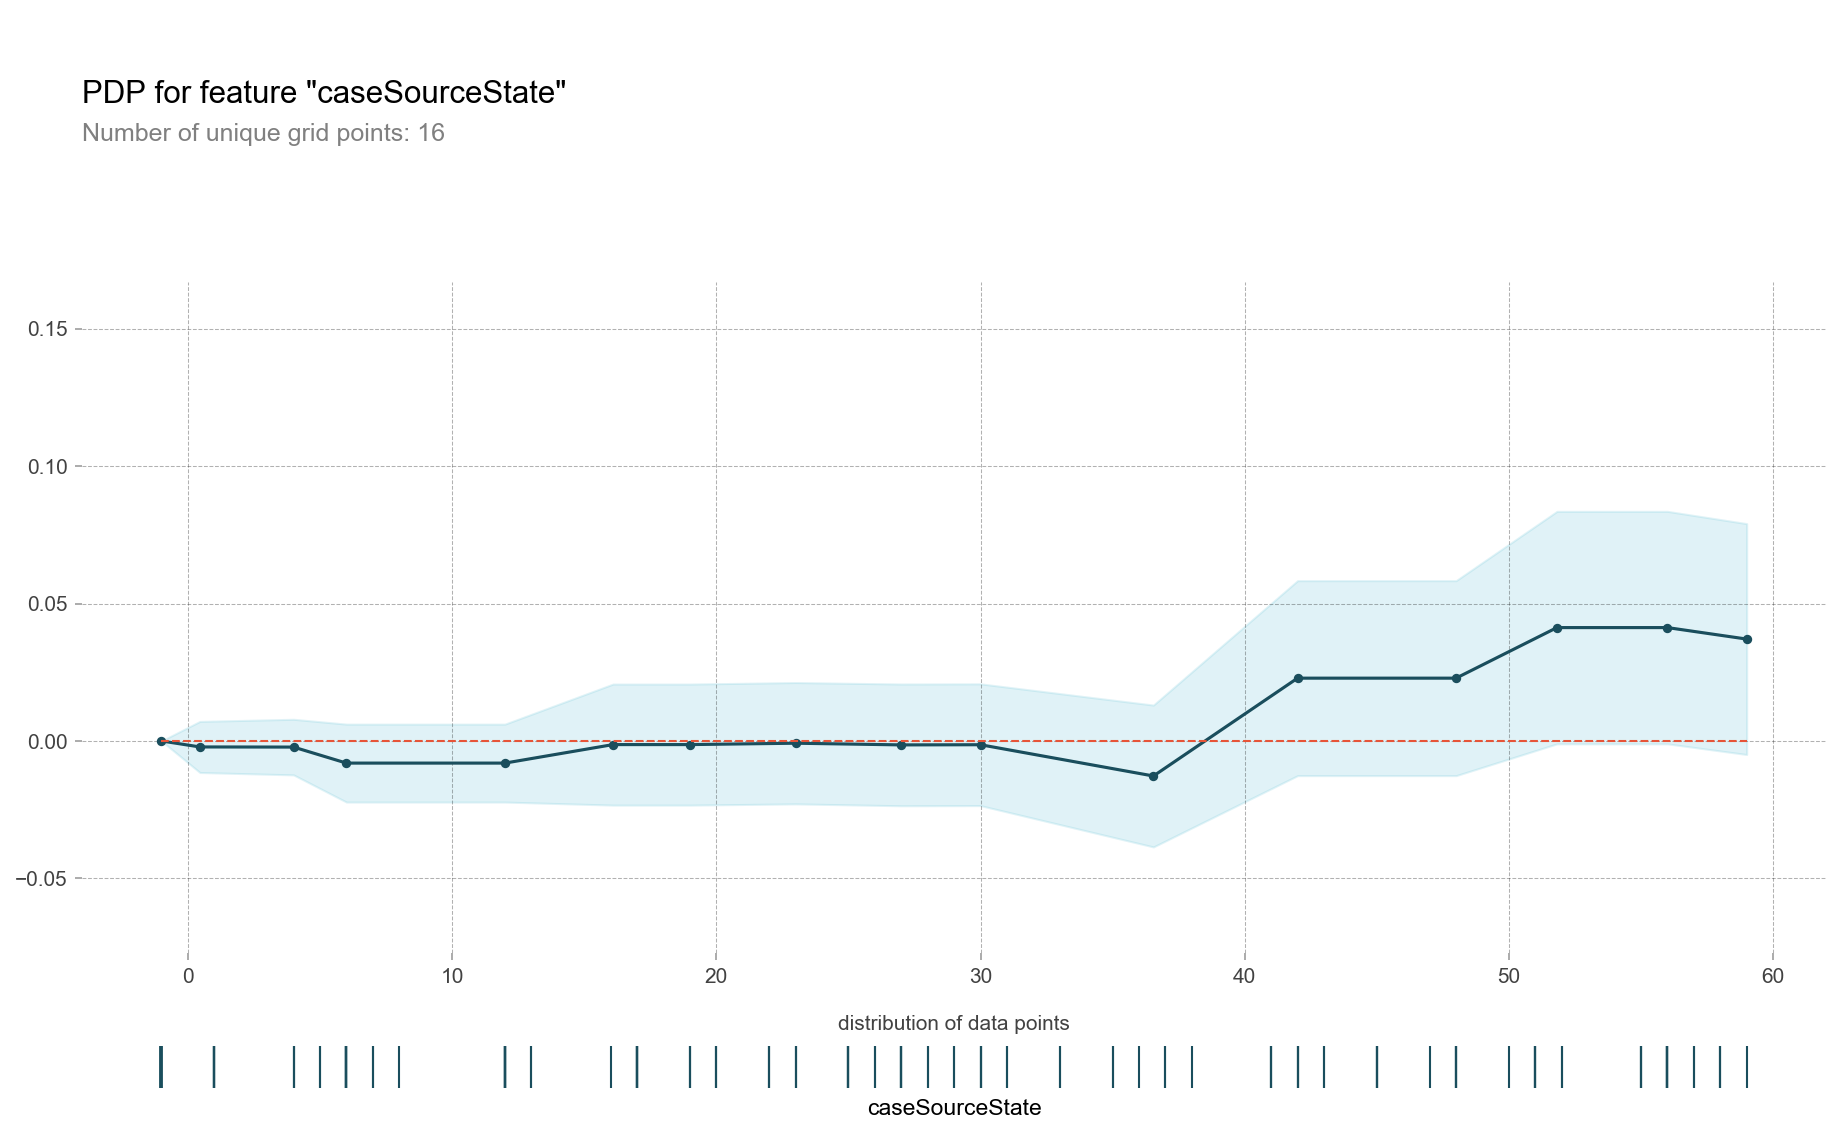

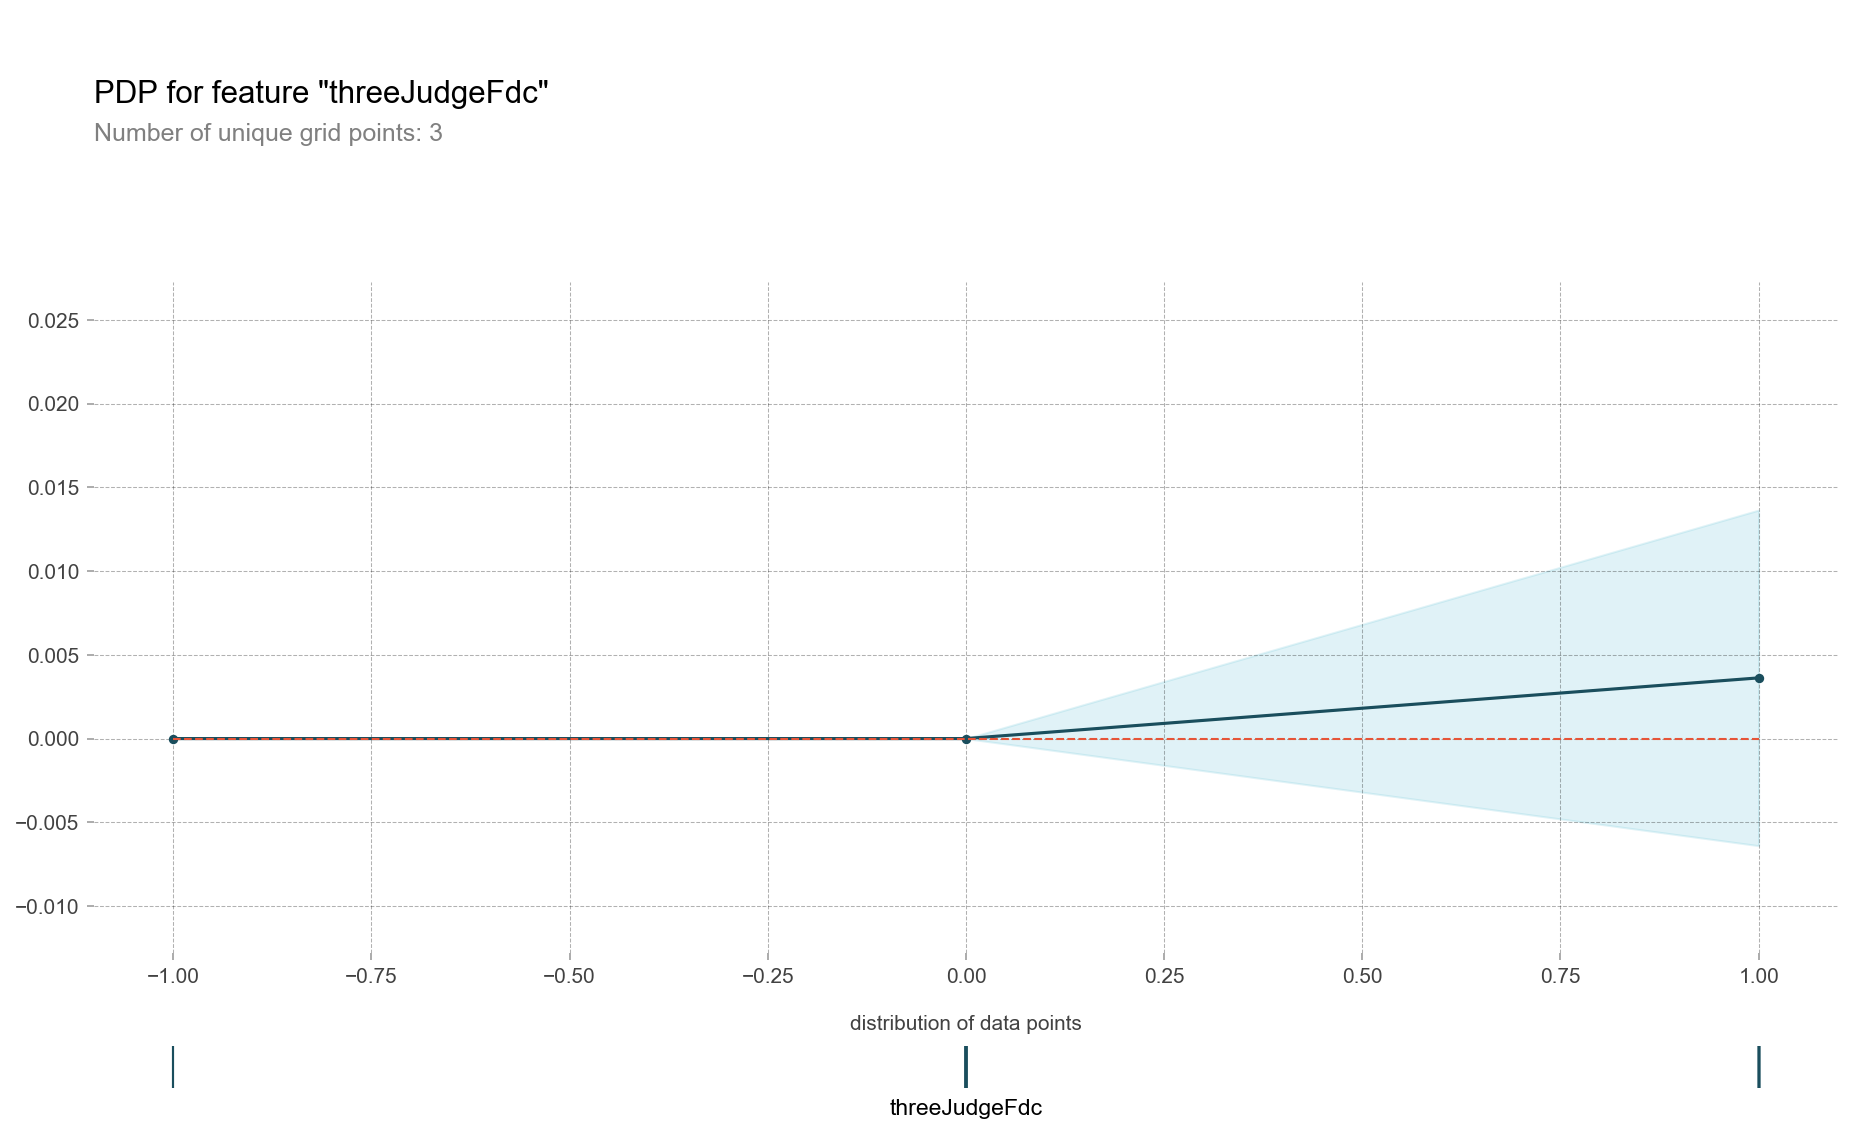

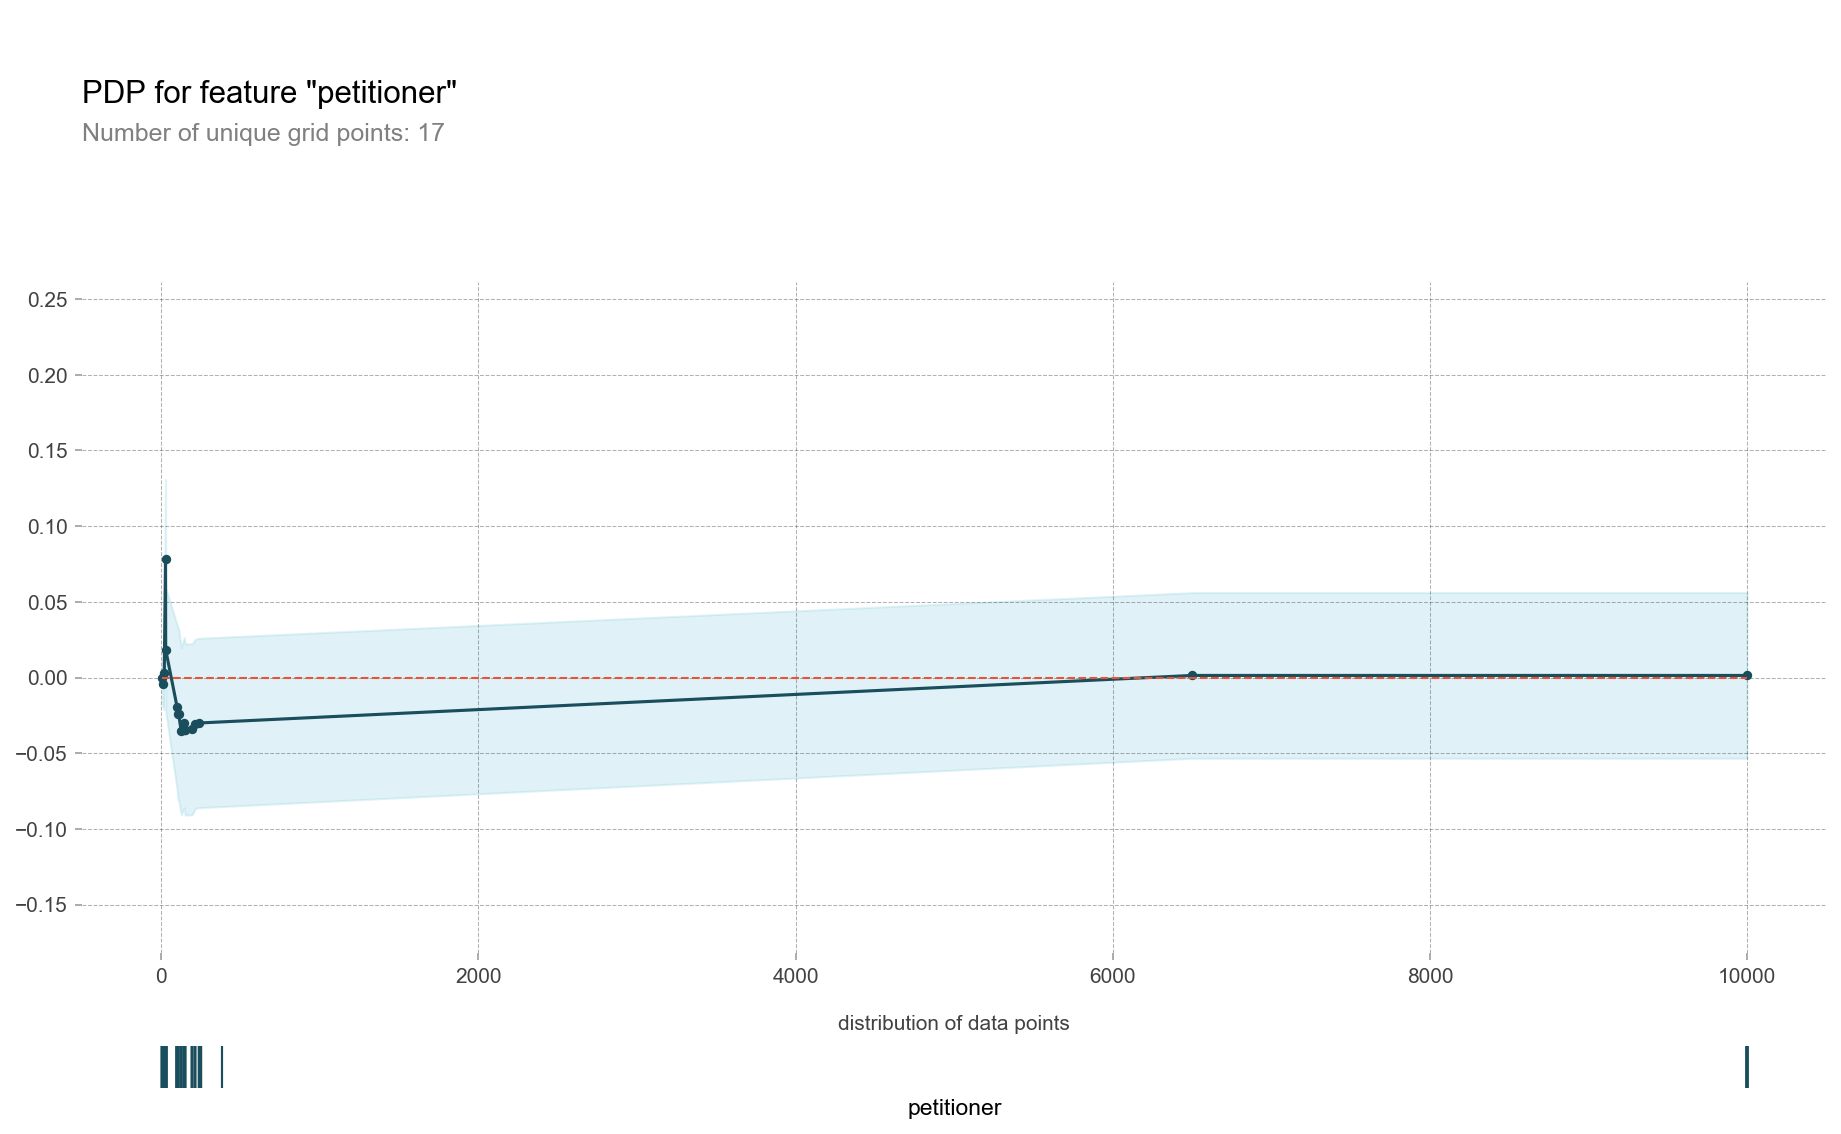

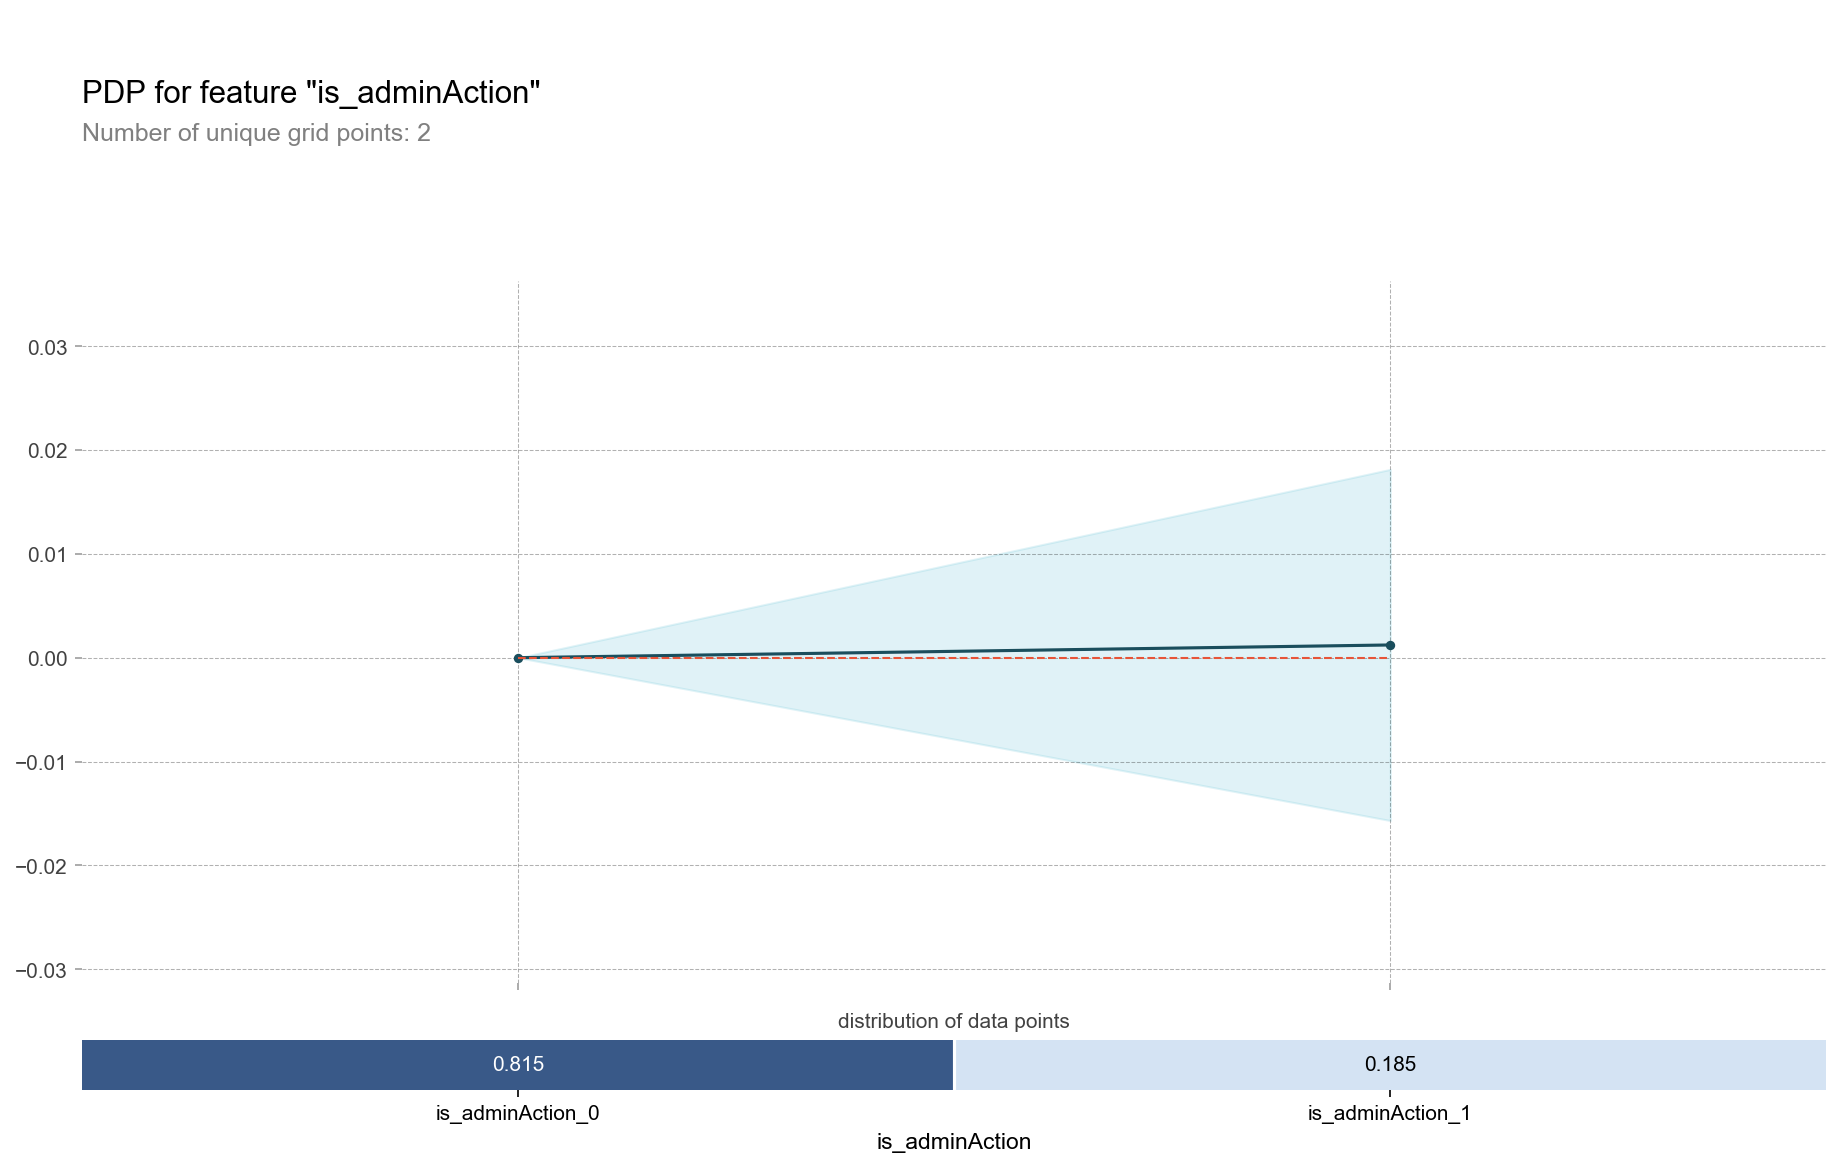

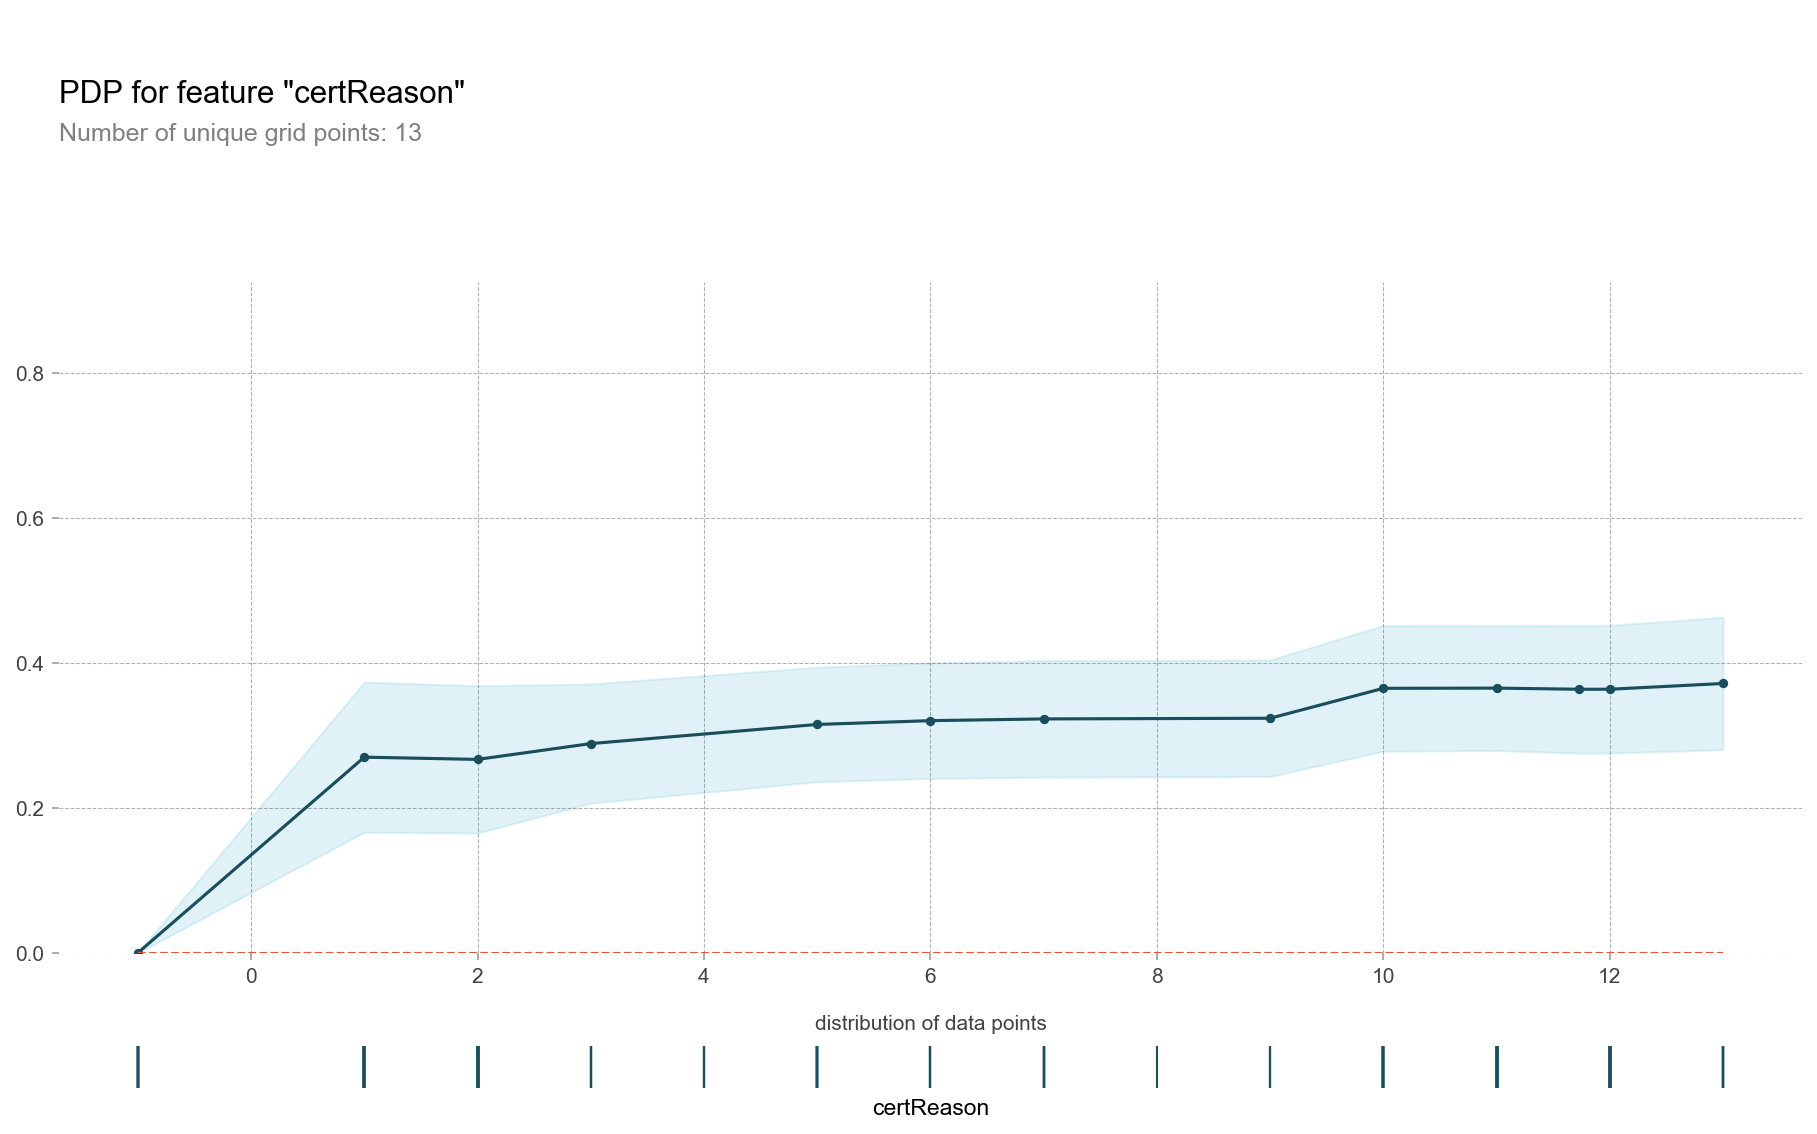

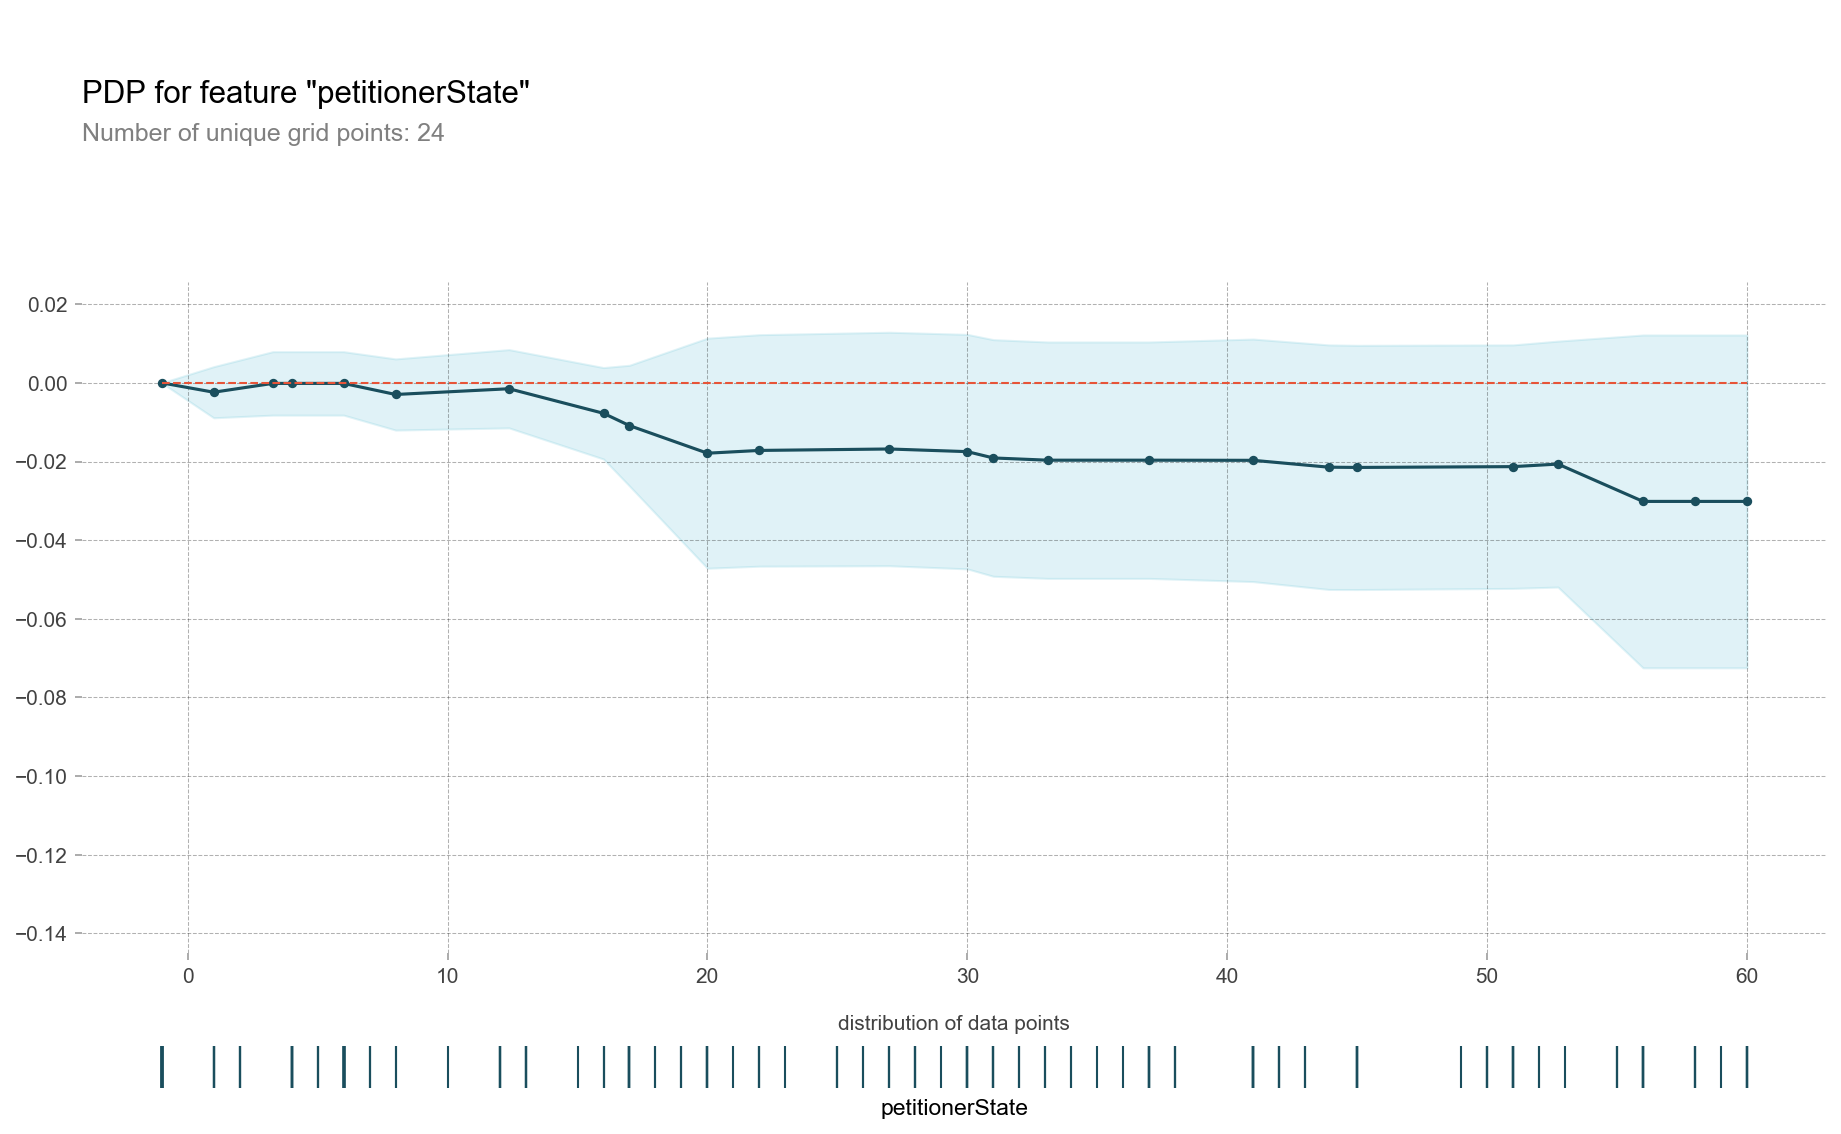

In [44]:
#Plotting for partial plots for all features

plt.rcParams['figure.dpi'] = 150
#Plotting pdp plot for each of the features
for f in selected_features:

    isolated = pdp_isolate(
    model=xgboost,
    dataset=val[selected_features],
    model_features=selected_features,
    feature=f,
    num_grid_points=100)

    pdp_plot(isolated,feature_name=f,plot_pts_dist=True)

In [45]:
import shap
explainer = shap.TreeExplainer(xgboost)
shap.initjs()

In [46]:
shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[2]][selected_features]),X_test.iloc[[2]][selected_features])


In [47]:
shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[3]][selected_features]),X_test.iloc[[3]][selected_features])


In [48]:
selected_features

['caseSource',
 'caseOriginState',
 'respondent',
 'lcDisagreement',
 'issueArea',
 'case_reargued',
 'case_argued',
 'lcDisposition',
 'respondentState',
 'caseSourceState',
 'threeJudgeFdc',
 'petitioner',
 'is_adminAction',
 'certReason',
 'petitionerState']

In [49]:
fig = shap.force_plot(explainer.expected_value,explainer.shap_values(X_test.iloc[[3]][selected_features]),X_test.iloc[[3]][selected_features])


In [50]:
perm_xgboost = PermutationImportance(xgboost, random_state=1,scoring='roc_auc').fit(X_val[selected_features], y_val)
eli5.show_weights(perm_xgboost,feature_names=selected_features,top=None)

Weight,Feature
0.0360 ± 0.0076,certReason
0.0153 ± 0.0053,case_argued
0.0146 ± 0.0080,respondent
0.0142 ± 0.0094,petitioner
0.0113 ± 0.0097,lcDisposition
0.0112 ± 0.0180,issueArea
0.0089 ± 0.0081,lcDisagreement
0.0071 ± 0.0025,respondentState
0.0033 ± 0.0042,caseSourceState
0.0030 ± 0.0039,petitionerState


(<Figure size 1125x1425 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff4cc883210>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff4cc866050>})

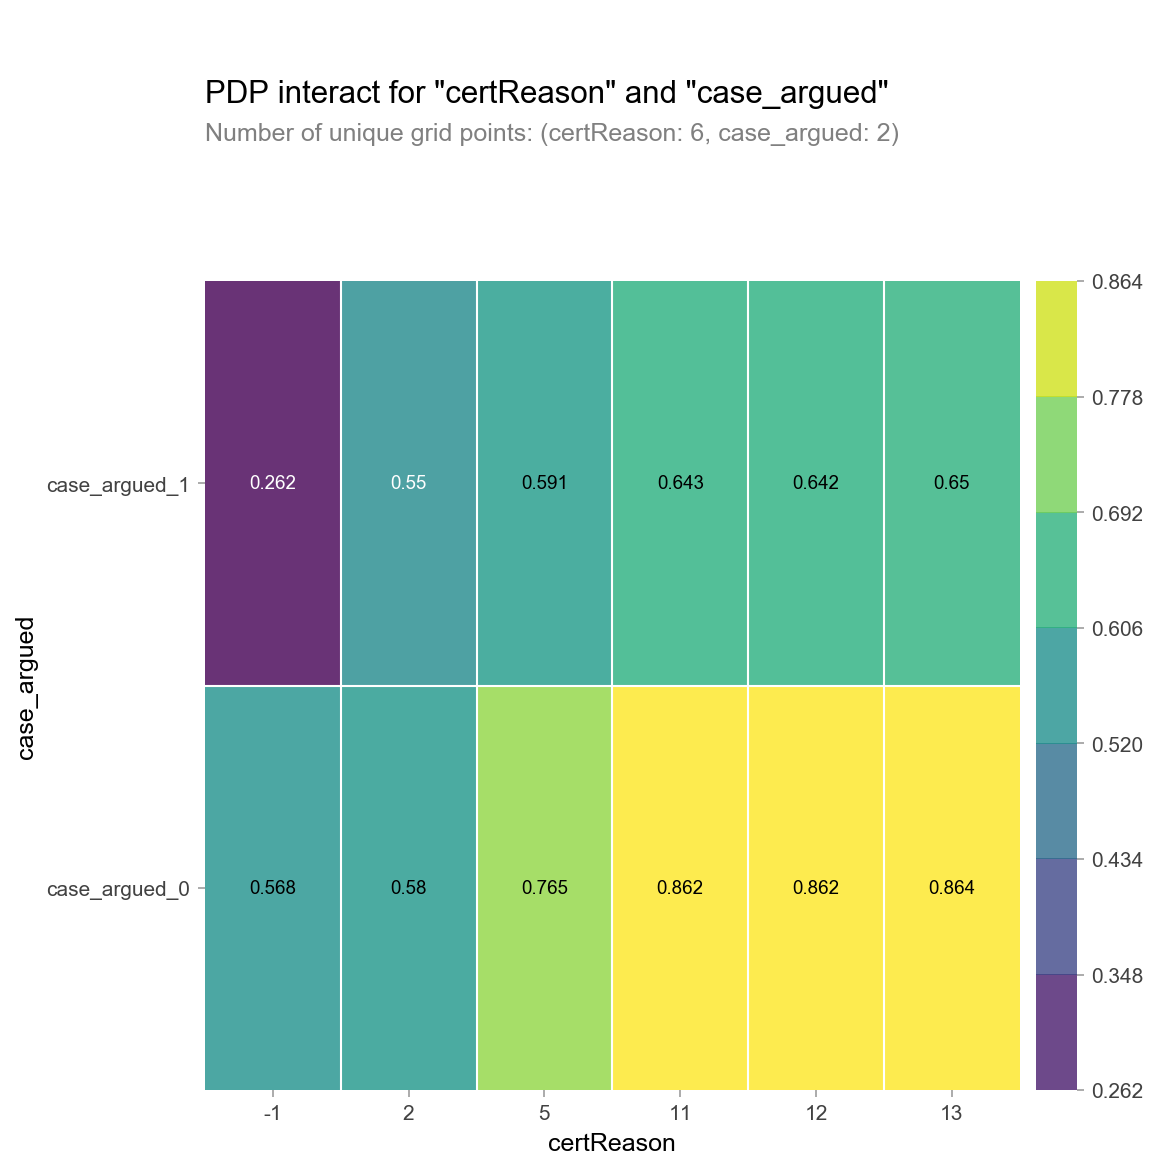

In [52]:

#interaction plot between top two features
interact = pdp_interact(model=xgboost,dataset=test[selected_features],model_features=selected_features,features=['certReason','case_argued'])
pdp_interact_plot(interact,feature_names=['certReason','case_argued'],plot_type='grid')

In [53]:
X_train[selected_features].nunique()

caseSource         34
caseOriginState    53
respondent         16
lcDisagreement      3
issueArea          14
case_reargued       2
case_argued         2
lcDisposition      13
respondentState    56
caseSourceState    53
threeJudgeFdc       3
petitioner         16
is_adminAction      2
certReason         13
petitionerState    57
dtype: int64

In [54]:
len(features),len(selected_features)

(18, 15)

In [55]:
from sklearn.metrics import roc_curve

In [56]:
falsepositive,truepositive,thresholds = roc_curve(y_test,xgboost.predict_proba(X_test[selected_features])[:,1])

Text(0, 0.5, 'True Positive Rate')

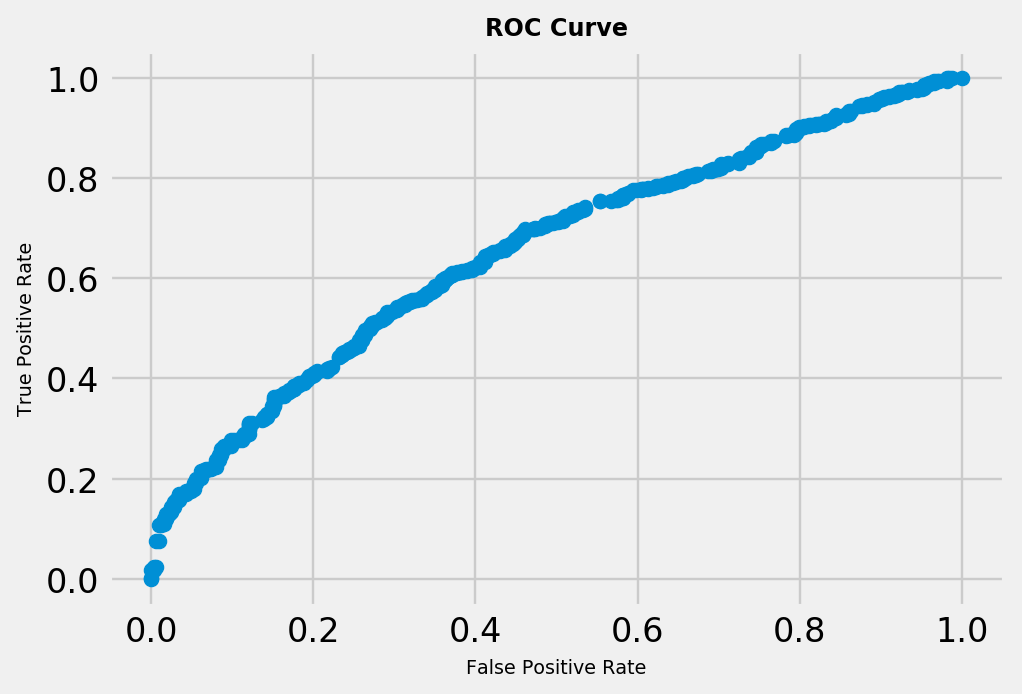

In [57]:
plt.style.use('fivethirtyeight')
fig = plt.figure(dpi=172)
plt.scatter(falsepositive,truepositive)
plt.title('ROC Curve', fontweight = 'bold', fontsize = 10)
plt.xlabel('False Positive Rate', fontsize = 8)
plt.ylabel('True Positive Rate', fontsize = 8)

In [58]:
#getting a test value for generating shap value
shaprow = X_test[selected_features].sample(1,random_state=5)
print("The probability of winning the case is ",xgboost.predict_proba(shaprow))

The probability of winning the case is  [[0.5288222 0.4711778]]


In [59]:
#Generating the shapvalue for the selected test row
shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)

In [60]:
#Now, lets see the predicted probablit when the certReason is changed to 10
shaprow['certReason']=10
print("The probability of winning the case is ",xgboost.predict_proba(shaprow))

The probability of winning the case is  [[0.4013872 0.5986128]]


In [61]:
shap.force_plot(explainer.expected_value,explainer.shap_values(shaprow),shaprow)


In [94]:
from joblib import dump
dump(xgboost, '../assets/xgboost.joblib')

['../assets/xgboost.joblib']

In [91]:
set(columns)&set(selected_features)

{'caseOriginState',
 'caseSource',
 'caseSourceState',
 'case_argued',
 'certReason',
 'issueArea',
 'lcDisagreement',
 'lcDisposition',
 'petitioner',
 'petitionerState',
 'respondent',
 'respondentState',
 'threeJudgeFdc'}

In [92]:
len(columns),len(selected_features)

(13, 15)

In [63]:
predict_data = pd.DataFrame(
    columns = ['threeJudgeFdc', 'petitioner', 'case_argued', 'lcDisposition', 'respondent', 
        'certReason', 'caseOriginState', 'petitionerState', 'lcDisagreement', 'respondentState',
         'caseSourceState', 'issueArea', 'caseSource'],
    #Hard coding threejudgefdc, need to get the input later
    data = [[1, 28, 0, 1, 126, 8, -1, -1, 1, -1, -1, 1, 28]]
         )

[
  'case_argued',    
 , , 'is_adminAction',  ]

In [64]:
xgboost.predict_proba(predict_data)

ValueError: feature_names mismatch: ['caseSource', 'caseOriginState', 'respondent', 'lcDisagreement', 'issueArea', 'case_reargued', 'case_argued', 'lcDisposition', 'respondentState', 'caseSourceState', 'threeJudgeFdc', 'petitioner', 'is_adminAction', 'certReason', 'petitionerState'] ['threeJudgeFdc', 'petitioner', 'case_argued', 'lcDisposition', 'respondent', 'certReason', 'caseOriginState', 'petitionerState', 'lcDisagreement', 'respondentState', 'caseSourceState', 'issueArea', 'caseSource']
expected is_adminAction, case_reargued in input data

In [ ]:
features

In [65]:
selected_features

['caseSource',
 'caseOriginState',
 'respondent',
 'lcDisagreement',
 'issueArea',
 'case_reargued',
 'case_argued',
 'lcDisposition',
 'respondentState',
 'caseSourceState',
 'threeJudgeFdc',
 'petitioner',
 'is_adminAction',
 'certReason',
 'petitionerState']

In [ ]:
#ax.savefig('../assets/partialplot',dpi=172)